In [1]:
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <https://www.gnu.org/licenses/>.


import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import itertools, os
from pathlib import Path



In [2]:
width = 7.16808
width_small = 3.50069
max_height = 9.77885

rc_fonts = {
    "font.family": "serif",
    "font.size": 9.5,
    #"text.usetex": True,
    #'text.latex.preamble': r'\usepackage{mathpazo}'
    }
matplotlib.rcParams.update(rc_fonts)

out_folder = Path('./figures')
if not out_folder.exists():
    out_folder.mkdir()
base_csv_path = Path('/home/chesetti/Repos/arqf/arqf/paper_results/results')
if not out_folder.exists():
    raise FileNotFoundError(
        "error, cannot find the results folder")

range_filters = ['memento', 'arqf'] #, 'snarf', 'surf', 'proteus', 'rosetta', 'rencoder']
range_filters_style_kwargs = {'memento': {'marker': '4', 'color': 'C1', 'zorder': 11, 'label': 'Memento'},
                              'grafite': {'marker': 'o', 'color': 'dimgray', 'zorder': 10, 'label': 'Grafite'},
                              'none': {'marker': 'x', 'color': 'dimgray', 'zorder': 10, 'label': 'Baseline'},
                              'snarf': {'marker': '^', 'color': 'C1', 'label': 'SNARF'},
                              'surf': {'marker': 's', 'color': 'C2', 'label': 'SuRF'},
                              'proteus': {'marker': 'X', 'color': 'C3', 'label': 'Proteus'},
                              'arqf': {'marker': 'X', 'color': 'C2', 'label': 'RQF'},
                              'adaptive_arqf_inmem': {'marker': '>', 'color': 'C3', 'label': 'ARQF(std::map)'},
                              'adaptive_arqf_splinterdb': {'marker': 'd', 'color': 'C5', 'label': 'ARQF'},
                              'rosetta': {'marker': 'd', 'color': 'C4', 'label': 'Rosetta'},
                              'rencoder': {'marker': '>', 'color': 'C5', 'label': 'REncoder'}}
b_tree_range_filters_style_kwargs = {'memento': {'marker': '4', 'color': 'fuchsia', 'zorder': 11, 'label': 'Memento'},
                                           'none': {'marker': 'x', 'color': 'dimgray', 'zorder': 10, 'label': 'Baseline'}}

range_filters_cmaps = {'memento': {'cmap': cm.PuRd}, 
                       'grafite': {'cmap': cm.Greys}, 
                       'none': {'cmap': cm.Greys}, 
                       'snarf': {'cmap': cm.Oranges},
                       'surf': {'cmap': cm.Greens},
                       'proteus': {'cmap': cm.Reds},
                       'rosetta': {'cmap': cm.Purples},
                       'arqf': {'cmap': cm.Purples}
                       }

empty_markers_style = {'linestyle': ':', 'fillstyle': 'none', 'alpha': 0.6, 'markersize': 4}
lines_style = {'markersize': 4, 'linewidth': 0.7, 'fillstyle': 'none'}


keys_synth = ['kuniform']
query_synth = ['qcorrelated', 'quniform']

labels_name = {'kuniform': r'Uniform', 
               'knormal': r'Normal',
               'qcorrelated': r'Correlated', 
               'qcorrelated-zipf': r'Correlated',
               'quniform': r'Uniform (corr=0.8)',
               'qzipfian': r'Zipfian',
               'books': r'Books',
               'osm': r'Osm',
               'fb': r'Fb'}

keys_real = ['books', 'osm', 'fb']
query_range = [0, 5, 10]
query_range_label = ["Point Queries", "Short Range Queries", "Long Range Queries", "Mixed Range Queries"]
vertical_query_range_label = ["Point", "Short Range", "Long Range", "Mixed Range Queries"]
query_result_label = {
    0: "point", 
    5: "short", 
    10: "long"
}

datasets_synth = list(itertools.product(keys_synth, query_synth))
datasets_real = keys_real

fpr_test_path = f'{base_csv_path}/fpr_test'
def get_file(filter, range_size, dataset_name, query_name = "", path=fpr_test_path):
    if dataset_name in keys_synth or query_name:
        p = Path(f'{path}/{dataset_name}/{range_size}_{query_name}/{filter}.csv')
    else:
        p = Path(f'{path}/{dataset_name}/{range_size}/{filter}.csv')
    if not p.exists:
        raise FileNotFoundError(f'error, {p} does not exist')
    return p

title_font_size = 9.5
legend_font_size = 7
ylabel_font_size = 9.5
xlabel_font_size = 9.5

max_x_axis_bpk = 30

In [3]:

def mean_insert_bulkload(filters, workloads, test_type, ranges=[0,5,10], dataset='kuniform'):
    iterate = list(itertools.product(workloads, filters, enumerate(ranges)))
    filter_data = {}
    for (x, ds, r) in iterate:
        data = pd.read_csv(os.path.join(adaptivity_dir, dataset, f'{r[1]}_{x}_trial_0', f'{ds}_{test_type}.csv'))
        if ds not in filter_data:
            filter_data[ds] = data[['n_keys', 'build_time', 'insert_time']]
        else:
            filter_data[ds] = pd.concat([filter_data[ds], data[['n_keys', 'build_time', 'insert_time']]])



    for filter in filters:
        df = filter_data[filter]
        df['build_time'] = df['n_keys'] * 1000 / df['build_time']
        df['insert_time'] = df['n_keys'] * 1000 / df['insert_time']
        display(df.groupby(['n_keys']).mean())
        df.groupby(['n_keys']).mean().to_csv(os.path.join(adaptivity_dir, f'{filter}_insert.csv'))


def plot_metric(filters, workloads, test_type, x_metric, x_label, y_metric, y_label, figname, use_logscale=True, title='', ranges=[0,5,10], x_max=max_x_axis_bpk, use_fpr_ticks=False, dataset='kuniform'):
    nrows = len(workloads)
    ncols = len(ranges)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey='row', figsize=(width * 0.8, nrows * max_height/6.4))
    iterate = list(itertools.product(workloads, filters, enumerate(ranges)))

    for (x, ds, r) in iterate:
        row = workloads.index(x)
        (idx, ran) = r
        data = pd.read_csv(os.path.join(adaptivity_dir, dataset, f'{r[1]}_{x}_trial_0', f'{ds}_{test_type}.csv'))
        if 'adversarial_rate' in data:
            data['adversarial_pct'] = data['adversarial_rate'] * 100.0
        data['query_throughput'] = data['n_queries'] /(data['query_time'] / 1000)
        data['fpr_opt'] = data['false_positives'] / data['n_queries']
        #data['fpr_r_bits'] = data['false_positives'] / data['n_filter_queries']
        data.plot(x_metric, y_metric, ax=axes[idx], **range_filters_style_kwargs[ds], **lines_style)
        data[[x_metric, y_metric]].to_csv(os.path.join(adaptivity_dir, f"{x}_{dataset}_{figname}_{ds}_{query_result_label[r[1]]}.csv"))
        print(f"{ds} mean: {data[y_metric].mean()}")
        #print(f"{ds} {figname}")
        #display(data[[x_metric, y_metric]])

    for ax in axes.flatten():
        if use_fpr_ticks:
            ticks = [1, 1e-01, 1e-02, 1e-03, 1e-04, 1e-05, 1e-06, 0]
            ax.set_yticks(ticks)
            ax.set_ylim(bottom=-0.0000003, top=1.9)

        if use_logscale:
            ax.set_yscale('symlog', linthresh=(1e-06))
            ax.yaxis.set_minor_locator(matplotlib.ticker.LogLocator(numticks=10, subs="auto"))
        ax.set_xlim(left=0, right=x_max)
        #ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(2))
        ax.set_xlabel(x_label, fontsize=xlabel_font_size)
        ax.get_legend().remove()
        ax.autoscale_view()
        ax.margins(0.04)

    for i, k in list(enumerate(workloads)):
        if type(k) is tuple:
            axis_title = f'{labels_name[k[1]]}'
        else:
            axis_title = f'{labels_name[k]}'
        axes[0].set_ylabel(axis_title + "\n" + y_label, fontsize=ylabel_font_size)

    for i, _ in list(enumerate(query_range)):
        axes[i].set_title(query_range_label[i], fontsize=title_font_size)

    fig.subplots_adjust(wspace=0.1)
    fig.savefig(os.path.join(adaptivity_dir, dataset, f'{figname}_nolegend.pdf'), bbox_inches='tight', pad_inches=0.01)
    lines, labels = axes[1].get_legend_handles_labels()

    if len(filters) > 4:
        ncol = (len(filters) + 1) // 2
        bbox = (0.5, 1.65)
    else:
        ncol = len(filters)
        bbox = (0.5, 1.65)

    axes[1].legend(lines, labels, loc='upper center', bbox_to_anchor=bbox, 
            fancybox=True, shadow=False, ncol=ncol, fontsize=9)
    fig.savefig(os.path.join(adaptivity_dir, dataset, f'{figname}.pdf'), bbox_inches='tight', pad_inches=0.01)

In [4]:

def plot_adversarial_metric(
        filters, workloads, test_type, x_metric, x_label, y_metric, y_label, figname, title='', ranges=[0,5,10]):
    cache_sizes = [1, 5, 25]
    nrows = len(ranges)
    ncols = 3 # 3 cache sizes (1%, 5%, 25%)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey='row', figsize=(width * 0.8, nrows * max_height/6.4))
    iterate = list(itertools.product(workloads, filters, enumerate(ranges)))

    for (x, ds, r) in iterate:
        row = r[0]
        data = pd.read_csv(os.path.join(adaptivity_dir, 'kuniform', f'{r[1]}_{x}_trial_0', f'{ds}_{test_type}.csv'))
        data['adversarial_pct'] = data['adversarial_rate'] * 100.0
        data['cache_pct'] = (data['wt_buffer_pool_size_mb'] * 1024 * 1024) / (data['n_keys'] * 512) * 100.0
        data['cache_pct'] = data['cache_pct'].round(0).astype(int)
        data['query_throughput'] = data['n_queries'] /(data['query_time'] / 1000)
        for cache_pct in cache_sizes:
            tmp = data.loc[data['cache_pct'] == cache_pct]
            tmp.plot(x_metric, y_metric, ax=axes[row][cache_sizes.index(cache_pct)], **range_filters_style_kwargs[ds], **lines_style)
            tmp[[x_metric, y_metric]].to_csv(os.path.join(adaptivity_dir, f"{figname}_{ds}_{query_result_label[r[1]]}_cache_{cache_pct}.csv"))

    for ax in axes.flatten():
        ax.set_yscale('log')
        ax.yaxis.set_minor_locator(matplotlib.ticker.LogLocator(numticks=10, subs="auto"))
        #ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(2))
        ax.set_xlabel(x_label, fontsize=xlabel_font_size)
        ax.get_legend().remove()
        ax.autoscale_view()
        ax.margins(0.08)

    for row in range(nrows):
        axes[row][0].set_ylabel(vertical_query_range_label[row] + "\n" + "[ops/sec]")
    for col in range(ncols):
        axes[0][col].set_title(f"{cache_sizes[col]}% Cache size", fontsize=title_font_size)
        axes[2][col].set_xticks([1, 5, 10])

    fig.subplots_adjust(wspace=0.1)
    fig.savefig(os.path.join(adaptivity_dir, 'kuniform', f'{figname}_nolegend.pdf'), bbox_inches='tight', pad_inches=0.01)
    lines, labels = axes[0][0].get_legend_handles_labels()

    if len(filters) > 4:
        ncol = (len(filters) + 1) // 2
        bbox = (0.5, 1.65)
    else:
        ncol = len(filters)
        bbox = (0.5, 1.65)

    axes[0][1].legend(lines, labels, loc='upper center', bbox_to_anchor=bbox, 
            fancybox=True, shadow=False, ncol=ncol, fontsize=9)
    fig.savefig(os.path.join(adaptivity_dir, 'kuniform', f'{figname}.pdf'), bbox_inches='tight', pad_inches=0.01)

# False Positive Rate

adaptive_arqf_inmem mean: 2.3696666666666666e-05
adaptive_arqf_inmem mean: 0.0002499233333333333
adaptive_arqf_inmem mean: 0.00013036625
memento mean: 0.0054219425
memento mean: 0.09769155249999999
memento mean: 0.01887030125
surf mean: 0.43365466
surf mean: 1.361e-06
surf mean: 1.404e-06
snarf mean: 0.0212566775
snarf mean: 0.021252169999999997
snarf mean: 0.02125416916666667
grafite mean: 0.0006050683333333333
grafite mean: 0.09409037250000002
grafite mean: 0.2768298275
adaptive_arqf_inmem mean: 4.5295e-05
adaptive_arqf_inmem mean: 0.000247385
adaptive_arqf_inmem mean: 0.00013007125
memento mean: 0.011793273333333335
memento mean: 0.07410359083333333
memento mean: 0.16521462374999998
surf mean: 0.025606414999999997
surf mean: 2.392583333333333e-05
surf mean: 2.3971666666666663e-05
snarf mean: 0.004277274166666668
snarf mean: 0.004279345
snarf mean: 0.004278434166666667
grafite mean: 0.0037516016666666666
grafite mean: 0.155119925
grafite mean: 0.3004319141666667
adaptive_arqf_inmem m

FileNotFoundError: [Errno 2] No such file or directory: '/home/chesetti/Repos/arqf/arqf/experiments/results/04-02-25/workloads/inserts/kuniform/0_qcorrelated-zipf_trial_0/arqf_inserts.csv'

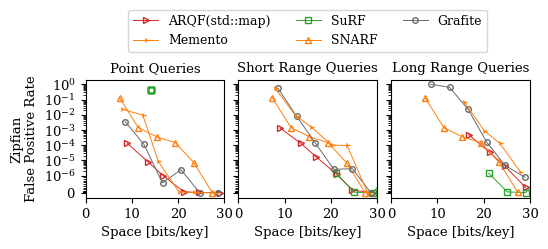

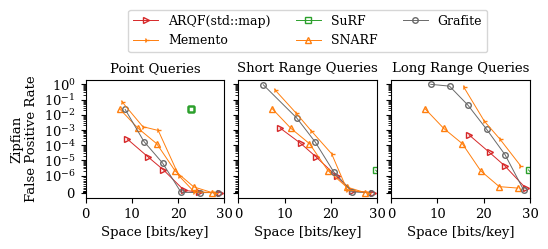

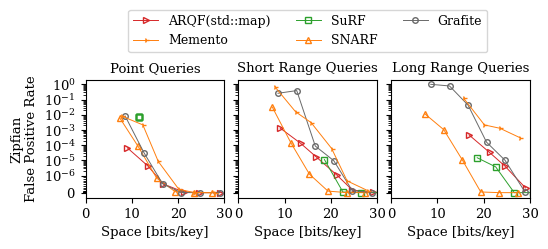

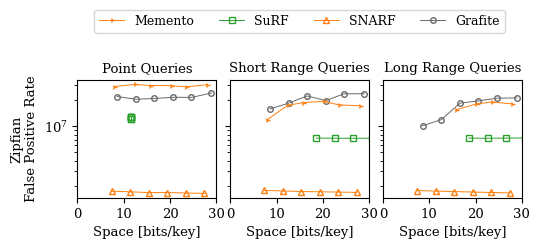

In [5]:
filters = ['adaptive_arqf_inmem', 'memento', 'surf', 'snarf', 'grafite']
adaptivity_dir = Path('/home/chesetti/Repos/arqf/arqf/experiments/results/27-01-25/workloads/large/')
plot_metric(filters=filters, workloads=['qzipfian'], test_type='fpr', x_metric='bpk', x_label="Space [bits/key]", y_metric='fpr_opt', y_label="False Positive Rate", figname='false_positive_rate', use_logscale=True, use_fpr_ticks=True, dataset='osm')
plot_metric(filters=filters, workloads=['qzipfian'], test_type='fpr', x_metric='bpk', x_label="Space [bits/key]", y_metric='fpr_opt', y_label="False Positive Rate", figname='false_positive_rate', use_logscale=True, use_fpr_ticks=True, dataset='books')
plot_metric(filters=filters, workloads=['qzipfian'], test_type='fpr', x_metric='bpk', x_label="Space [bits/key]", y_metric='fpr_opt', y_label="False Positive Rate", figname='false_positive_rate', use_logscale=True, use_fpr_ticks=True, dataset='kuniform')
#plot_metric(filters=filters, workloads=['qcorrelated-zipf'], test_type='fpr', x_metric='bpk', x_label="Space [bits/key]", y_metric='fpr_opt', y_label="False Positive Rate", figname='false_positive_rate', use_logscale=True, use_fpr_ticks=True, dataset='kuniform')

filters = ['memento', 'surf', 'snarf', 'grafite']
adaptivity_dir = Path('/home/chesetti/Repos/arqf/arqf/experiments/results/27-01-25/workloads/large/')
plot_metric(filters=filters, workloads=['qzipfian'], test_type='fpr', x_metric='bpk', x_label="Space [bits/key]", y_metric='query_throughput', y_label="False Positive Rate", figname='query', use_logscale=True, use_fpr_ticks=False, dataset='kuniform')
#plot_metric(filters=filters, workloads=['qzipfian'], test_type='fpr', x_metric='bpk', x_label="Space [bits/key]", y_metric='query_throughput', y_label="False Positive Rate", figname='query', use_logscale=True, use_fpr_ticks=False, dataset='osm')
#plot_metric(filters=filters, workloads=['qzipfian'], test_type='fpr', x_metric='bpk', x_label="Space [bits/key]", y_metric='query_throughput', y_label="False Positive Rate", figname='query', use_logscale=True, use_fpr_ticks=False, dataset='books')

filters = ['arqf', 'memento', 'surf', 'grafite', 'snarf']
adaptivity_dir = Path('/home/chesetti/Repos/arqf/arqf/experiments/results/04-02-25/workloads/large/')
mean_insert_bulkload(filters=filters, workloads=['qcorrelated-zipf'], test_type='inserts')

#filters = ['adaptive_arqf_splinterdb', 'memento']
#adaptivity_dir = Path('/home/chesetti/Repos/arqf/arqf/experiments/results/26-01-25/workloads/adversarial_large/')
#plot_adversarial_metric(filters=filters, workloads=['quniform'], test_type='adversarial_fpr13', x_metric='adversarial_pct', x_label="Adversarial(%)", y_metric='query_throughput', y_label="False Positive Rate", figname='adversarial')



## Old Stuff (Clean and remove) 

In [52]:
def plot_adaptivity_fpr(filters, workloads, name, test_type='adaptivity_inmem', ranges=[0,5,10]):
    nrows = 1 # len(workloads)
    ncols = len(ranges)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey='row', figsize=(2 * width * 0.7, 2 * nrows * max_height/6.4))

    iterate = list(itertools.product(workloads, filters, enumerate(ranges)))

    for (x, ds, r) in iterate:
        row = workloads.index(x)
        (idx, ran) = r
        print(os.path.join(adaptivity_dir, 'kuniform', f'{r[1]}_{x}_trial_0', f'{ds}_{test_type}.csv'))
        data = pd.read_csv(os.path.join(adaptivity_dir, 'kuniform', f'{r[1]}_{x}_trial_0', f'{ds}_{test_type}.csv'))
        data['fpr_opt'] = data['false_positives'] / data['n_queries']
        data.plot("bpk", "fpr", ax=axes[idx], **range_filters_style_kwargs[ds], **lines_style)
    
    ticks = [1, 1e-01, 1e-02, 1e-03, 1e-04, 1e-05, 1e-06, 0]
    for ax in axes.flatten():
        ax.set_yscale('symlog', linthresh=(1e-06))
        ax.set_xlim(left=0, right=max_x_axis_bpk)
        ax.set_yticks(ticks)
        ax.set_ylim(bottom=-0.0000003, top=1.9)
        #ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(2))
        ax.set_xlabel('Space [bits/key]', fontsize=xlabel_font_size)
        ax.get_legend().remove()
        ax.autoscale_view()
        ax.margins(0.04)

    for ax in axes:
        ax.yaxis.set_minor_locator(matplotlib.ticker.LogLocator(numticks=10, subs="auto"))
    for i, k in list(enumerate(workloads)):
        if type(k) is tuple:
            axis_title = f'{labels_name[k[1]]}'
        else:
            axis_title = f'{labels_name[k]}'
        axes[0].set_ylabel(axis_title + "\nFPR", fontsize=ylabel_font_size)
        
    for i, _ in list(enumerate(query_range)):
        axes[i].set_title(query_range_label[i], fontsize=title_font_size)

    fig.subplots_adjust(wspace=0.1)
    fig.savefig(os.path.join(adaptivity_dir, 'kuniform', f'{name}_nolegend.pdf'), bbox_inches='tight', pad_inches=0.01)
    lines, labels = axes[1].get_legend_handles_labels()

    if len(filters) > 4:
        ncol = (len(filters) + 1) // 2
        bbox = (0.5, 1.65)
    else:
        ncol = len(filters)
        bbox = (0.5, 1.25)

    axes[1].legend(lines, labels, loc='upper center', bbox_to_anchor=bbox, 
            fancybox=True, shadow=False, ncol=ncol, fontsize=9)
    fig.savefig(os.path.join(adaptivity_dir, 'kuniform', f'{name}.pdf'), bbox_inches='tight', pad_inches=0.01)

def plot_adaptivity_fpr_with_remainder(filters, workloads, name, test_type='adaptivity_inmem', ranges=[0,5,10]):
    nrows = 1 # len(workloads)
    ncols = 1
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey='row', figsize=(1 * width * 0.7, 2 * nrows * max_height/6.4))

    iterate = list(itertools.product(workloads, filters, enumerate(ranges)))

    for (x, ds, r) in iterate:
        row = workloads.index(x)
        (idx, ran) = r
        print(os.path.join(adaptivity_dir, 'kuniform', f'{r[1]}_{x}_trial_0', f'{ds}_{test_type}.csv'))
        data = pd.read_csv(os.path.join(adaptivity_dir, 'kuniform', f'{r[1]}_{x}_trial_0', f'{ds}_{test_type}.csv'))
        data['fpr_opt'] = data['false_positives'] / data['n_queries']
        print(f'q={r[1]}')
        display(data[['r_bits', 'false_positives']])
        data.plot("r_bits", "fpr", ax=axes, label=f'q={r[1]}', marker='o')

    axes.set_yscale('symlog', linthresh=(1e-06))
    ticks = [1, 1e-01, 1e-02, 1e-03, 1e-04, 1e-05, 1e-06, 0]
    axes.set_yticks(ticks)
    axes.autoscale_view()
    



def plot_adaptivity_query(filters, workloads, name, test_type='adaptivity_inmem', ranges=[0,5,10]):
    nrows = 1 # len(workloads)
    ncols = len(ranges)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey='row', figsize=(2 * width * 0.7, 2 * nrows * max_height/6.4))

    iterate = list(itertools.product(workloads, filters, enumerate(ranges)))

    for (x, ds, r) in iterate:
        row = workloads.index(x)
        (idx, ran) = r
        data = pd.read_csv(os.path.join(adaptivity_dir, 'kuniform', f'{r[1]}_{x}_trial_0', f'{ds}_{test_type}.csv'))
        data.plot("bpk", "query_time_ns", ax=axes[idx], **range_filters_style_kwargs[ds], **lines_style)
    
    for ax in axes.flatten():
        ax.set_yscale('symlog', linthresh=(1e-06))
        ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(2))
        ax.set_xlim(right=max_x_axis_bpk)
        ax.set_xlabel('Space [bits/key]', fontsize=xlabel_font_size)
        ax.get_legend().remove()
        ax.autoscale_view()
        ax.margins(0.04)

    for ax in axes:
        ax.yaxis.set_minor_locator(matplotlib.ticker.LogLocator(numticks=10, subs="auto"))
    for i, k in list(enumerate(workloads)):
        if type(k) is tuple:
            axis_title = f'{labels_name[k[1]]}'
        else:
            axis_title = f'{labels_name[k]}'
        axes[0].set_ylabel(axis_title + "\nQuery Time(ns)", fontsize=ylabel_font_size)
        
    for i, _ in list(enumerate(query_range)):
        axes[i].set_title(query_range_label[i], fontsize=title_font_size)

    fig.subplots_adjust(wspace=0.1)
    fig.savefig(os.path.join(adaptivity_dir, 'kuniform', f'{name}_query_time_nolegend.pdf'), bbox_inches='tight', pad_inches=0.01)
    lines, labels = axes[1].get_legend_handles_labels()

    if len(filters) > 4:
        ncol = (len(filters) + 1) // 2
        bbox = (0.5, 1.65)
    else:
        ncol = len(filters)
        bbox = (0.5, 1.25)

    axes[1].legend(lines, labels, loc='upper center', bbox_to_anchor=bbox, 
            fancybox=True, shadow=False, ncol=ncol, fontsize=9)
    fig.savefig(os.path.join(adaptivity_dir, 'kuniform', f'{name}_query_time.pdf'), bbox_inches='tight', pad_inches=0.01)

def plot_adaptivity_db_fetch_duration(filters, workloads, name, test_type='adaptivity_inmem', ranges=[0,5,10]):
    nrows = 1 # len(workloads)
    ncols = len(ranges)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey='row', figsize=(2 * width * 0.7, 2 * nrows * max_height/6.4))

    iterate = list(itertools.product(workloads, filters, enumerate(ranges)))

    for (x, ds, r) in iterate:
        row = workloads.index(x)
        (idx, ran) = r
        data = pd.read_csv(os.path.join(adaptivity_dir, 'kuniform', f'{r[1]}_{x}_trial_0', f'{ds}_{test_type}.csv'))
        data.plot("bpk", "db_fetch_duration_ns", ax=axes[idx], **range_filters_style_kwargs[ds], **lines_style)
    
    for ax in axes.flatten():
        ax.set_yscale('symlog', linthresh=(1e-06))
        ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(2))
        ax.set_xlim(right=max_x_axis_bpk)
        ax.set_xlabel('Space [bits/key]', fontsize=xlabel_font_size)
        ax.get_legend().remove()
        ax.autoscale_view()
        ax.margins(0.04)

    for ax in axes:
        ax.yaxis.set_minor_locator(matplotlib.ticker.LogLocator(numticks=10, subs="auto"))
    for i, k in list(enumerate(workloads)):
        if type(k) is tuple:
            axis_title = f'{labels_name[k[1]]}'
        else:
            axis_title = f'{labels_name[k]}'
        axes[0].set_ylabel(axis_title + "\nDB Fetch Duration(ns)", fontsize=ylabel_font_size)
        
    for i, _ in list(enumerate(query_range)):
        axes[i].set_title(query_range_label[i], fontsize=title_font_size)

    fig.subplots_adjust(wspace=0.1)
    fig.savefig(os.path.join(adaptivity_dir, 'kuniform', f'{name}_db_fetch_nolegend.pdf'), bbox_inches='tight', pad_inches=0.01)
    lines, labels = axes[1].get_legend_handles_labels()

    if len(filters) > 4:
        ncol = (len(filters) + 1) // 2
        bbox = (0.5, 1.65)
    else:
        ncol = len(filters)
        bbox = (0.5, 1.25)

    axes[1].legend(lines, labels, loc='upper center', bbox_to_anchor=bbox, 
            fancybox=True, shadow=False, ncol=ncol, fontsize=9)
    fig.savefig(os.path.join(adaptivity_dir, 'kuniform', f'{name}_db_fetch.pdf'), bbox_inches='tight', pad_inches=0.01)

def plot_adaptivity_overhead(filters, workloads, name, test_type='adaptivity_inmem', ranges=[0,5,10]):
    nrows = 1 # len(workloads)
    ncols = len(ranges)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey='row', figsize=(2 * width * 0.7, 2 * nrows * max_height/6.4))

    iterate = list(itertools.product(workloads, filters, enumerate(ranges)))

    for (x, ds, r) in iterate:
        row = workloads.index(x)
        (idx, ran) = r
        data = pd.read_csv(os.path.join(adaptivity_dir, 'kuniform', f'{r[1]}_{x}_trial_0', f'{ds}_{test_type}.csv'))
        data.plot("bpk", "adapt_duration_ns", ax=axes[idx], **range_filters_style_kwargs[ds], **lines_style)
    
    for ax in axes.flatten():
        ax.set_yscale('symlog', linthresh=(1e-06))
        ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(2))
        ax.set_xlim(right=max_x_axis_bpk)
        ax.set_xlabel('Space [bits/key]', fontsize=xlabel_font_size)
        ax.get_legend().remove()
        ax.autoscale_view()
        ax.margins(0.04)

    for ax in axes:
        ax.yaxis.set_minor_locator(matplotlib.ticker.LogLocator(numticks=10, subs="auto"))
    for i, k in list(enumerate(workloads)):
        if type(k) is tuple:
            axis_title = f'{labels_name[k[1]]}'
        else:
            axis_title = f'{labels_name[k]}'
        axes[0].set_ylabel(axis_title + "\nDB Adapt Duration (ns)", fontsize=ylabel_font_size)
        
    for i, _ in list(enumerate(query_range)):
        axes[i].set_title(query_range_label[i], fontsize=title_font_size)

    fig.subplots_adjust(wspace=0.1)
    fig.savefig(os.path.join(adaptivity_dir, 'kuniform', f'{name}_adapt_duration_nolegend.pdf'), bbox_inches='tight', pad_inches=0.01)
    lines, labels = axes[1].get_legend_handles_labels()

    if len(filters) > 4:
        ncol = (len(filters) + 1) // 2
        bbox = (0.5, 1.65)
    else:
        ncol = len(filters)
        bbox = (0.5, 1.25)

    axes[1].legend(lines, labels, loc='upper center', bbox_to_anchor=bbox, 
            fancybox=True, shadow=False, ncol=ncol, fontsize=9)
    fig.savefig(os.path.join(adaptivity_dir, 'kuniform', f'{name}_adapt_duration.pdf'), bbox_inches='tight', pad_inches=0.01)

def plot_insert_overhead(filters, workloads, name, test_type='adaptivity_disk', ranges=[0,5,10]):
    width_bars = 2.00  # Width of the bars
    nrows = 1 # len(workloads)
    ncols = len(ranges)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey='row', figsize=(2 * width * 0.7, 2 * nrows * max_height/6.4))

    iterate = list(itertools.product(workloads, filters, enumerate(ranges)))

    for (x, ds, r) in iterate:
        row = workloads.index(x)
        (idx, ran) = r
        data = pd.read_csv(os.path.join(adaptivity_dir, 'kuniform', f'{r[1]}_{x}_trial_0', f'{ds}_{test_type}.csv'))
        build_time = np.mean(data['build_time'])/data['n_keys'] * 10**6
        axes[idx].bar(filters.index(ds) * 2 * width_bars, build_time, width_bars, color=range_filters_style_kwargs[ds]['color'], label=f'{ds}')
    
    for ax in axes.flatten():
        ax.set_yscale('symlog', linthresh=(1e-06))
        ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(2))
        ax.autoscale_view()
        ax.margins(0.04)

    for ax in axes:
        ax.yaxis.set_minor_locator(matplotlib.ticker.LogLocator(numticks=10, subs="auto"))
    for i, k in list(enumerate(workloads)):
        if type(k) is tuple:
            axis_title = f'{labels_name[k[1]]}'
        else:
            axis_title = f'{labels_name[k]}'
        axes[0].set_ylabel(axis_title + "\nDB Adapt Duration (ms)", fontsize=ylabel_font_size)
        
    for i, _ in list(enumerate(query_range)):
        axes[i].set_title(query_range_label[i], fontsize=title_font_size)

    fig.subplots_adjust(wspace=0.1)
    fig.savefig(os.path.join(adaptivity_dir, 'kuniform', f'{name}_adapt_duration_nolegend.pdf'), bbox_inches='tight', pad_inches=0.01)
    lines, labels = axes[1].get_legend_handles_labels()

    if len(filters) > 4:
        ncol = (len(filters) + 1) // 2
        bbox = (0.5, 1.65)
    else:
        ncol = len(filters)
        bbox = (0.5, 1.25)

    axes[1].legend(lines, labels, loc='upper center', bbox_to_anchor=bbox, 
            fancybox=True, shadow=False, ncol=ncol, fontsize=9)
    fig.savefig(os.path.join(adaptivity_dir, 'kuniform', f'{name}_adapt_duration.pdf'), bbox_inches='tight', pad_inches=0.01)


In [54]:
filters = ['memento', 'arqf', 'adaptive_arqf_inmem']
adaptivity_dir = Path('/home/chesetti/Repos/arqf/arqf/workloads/medium/')
#plot_metric(filters=filters, workloads=['qzipfian'], test_type='fpr', x_metric='bpk', x_label="Space [bits/key]", y_metric='fpr_opt', y_label="FPR", figname='false_positive_rate', use_logscale=True)
print_fpr_with_r_bits(filters=['memento'], workloads=['quniform'])

,q_bits,r_bits,false_positives,filter_fpr
0,24,3,613118,0.03066
1,24,4,309499,0.01547
2,24,5,154952,0.00775
3,24,6,77549,0.00388
4,24,7,38868,0.00194
5,24,8,19626,0.00098
6,24,8,19626,0.00098
7,24,9,9897,0.00049
8,24,10,4982,0.00025
9,24,11,2465,0.00012


,q_bits,r_bits,false_positives,filter_fpr
0,24,0,12427275,0.31562
1,24,1,7777936,0.19754
2,24,2,4397269,0.11168
3,24,3,2343295,0.05951
4,24,4,1208819,0.03070
5,24,5,614926,0.01562
6,24,5,614926,0.01562
7,24,6,310444,0.00788
8,24,7,156000,0.00396
9,24,8,78137,0.00198


,q_bits,r_bits,false_positives,filter_fpr
0,24,0,12425318,0.31079
1,24,0,12425318,0.31079
2,24,1,7779225,0.19458
3,24,2,4394015,0.10990
4,24,3,2340940,0.05855
5,24,4,1208298,0.03022
6,24,5,614995,0.01538
7,24,6,309758,0.00775


# Mixed Workload

In [13]:
def plot_mixed_workload(filters, workloads, name, test_type='adaptivity_mixed', ranges=[0,5,10]):
    nrows = 1 # len(workloads)
    ncols = len(ranges)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey='row', figsize=(2 * width * 0.7, 2 * nrows * max_height/6.4))

    iterate = list(itertools.product(workloads, filters, enumerate(ranges)))

    for (x, ds, r) in iterate:
        row = workloads.index(x)
        (idx, ran) = r
        data = pd.read_csv(os.path.join(adaptivity_dir, 'kuniform', f'{r[1]}_{x}_trial_0', f'{ds}_{test_type}.csv'))
        data['fpr_opt'] = data['false_positives'] / data['n_queries']
        data['update_ratio'] = data['num_write_queries'] / (data['num_write_queries'] + data['num_read_queries']) * 100  
        data['update_throughput'] = 1000 * (data['num_write_queries'] + data['num_read_queries'])/ (data['mixed_workload_time'])
        data.plot("update_ratio", "update_throughput", ax=axes[idx], **range_filters_style_kwargs[ds], **lines_style)
    
    for ax in axes.flatten():
        ax.set_xticks([0, 25, 75, 100])
        ax.set_yscale('symlog', linthresh=(1e-06))
        ax.set_xlabel('Update percentage', fontsize=xlabel_font_size)
        ax.get_legend().remove()
        ax.autoscale_view()
        ax.margins(0.04)

    for i, k in list(enumerate(workloads)):
        if type(k) is tuple:
            axis_title = f'{labels_name[k[1]]}'
        else:
            axis_title = f'{labels_name[k]}'
        axes[0].set_ylabel(axis_title + "\nThroughput(ops/sec)", fontsize=ylabel_font_size)
        
    for ax in axes:
        ax.yaxis.set_minor_locator(matplotlib.ticker.LogLocator(numticks=10, subs="auto"))
    for i, _ in list(enumerate(query_range)):
        axes[i].set_title(query_range_label[i], fontsize=title_font_size)

    fig.subplots_adjust(wspace=0.1)
    fig.savefig(os.path.join(adaptivity_dir, 'kuniform', f'{name}_nolegend.pdf'), bbox_inches='tight', pad_inches=0.01)
    lines, labels = axes[1].get_legend_handles_labels()

    if len(filters) > 4:
        ncol = (len(filters) + 1) // 2
        bbox = (0.5, 1.65)
    else:
        ncol = len(filters)
        bbox = (0.5, 1.25)

    axes[1].legend(lines, labels, loc='upper center', bbox_to_anchor=bbox, 
            fancybox=True, shadow=False, ncol=ncol, fontsize=9)
    fig.savefig(os.path.join(adaptivity_dir, 'kuniform', f'{name}.pdf'), bbox_inches='tight', pad_inches=0.01)

def plot_mixed_bytes_read(filters, workloads, name, test_type='adaptivity_mixed', ranges=[0,5,10]):
    nrows = 1 # len(workloads)
    ncols = len(ranges)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey='row', figsize=(2 * width * 0.7, 2 * nrows * max_height/6.4))

    iterate = list(itertools.product(workloads, filters, enumerate(ranges)))

    for (x, ds, r) in iterate:
        row = workloads.index(x)
        (idx, ran) = r
        data = pd.read_csv(os.path.join(adaptivity_dir, 'kuniform', f'{r[1]}_{x}_trial_0', f'{ds}_{test_type}.csv'))
        data['fpr_opt'] = data['false_positives'] / data['n_queries']
        data['update_ratio'] = data['num_write_queries'] / (data['num_write_queries'] + data['num_read_queries']) * 100  
        data.plot("update_ratio", "bytes_read", ax=axes[idx], **range_filters_style_kwargs[ds], **lines_style)
    
    for ax in axes.flatten():
        ax.set_xticks([0, 25, 75, 100])
        ax.set_yscale('symlog', linthresh=(1e-06))
        ax.set_xlabel('Update percentage', fontsize=xlabel_font_size)
        ax.get_legend().remove()
        ax.autoscale_view()
        ax.margins(0.04)

    for i, k in list(enumerate(workloads)):
        if type(k) is tuple:
            axis_title = f'{labels_name[k[1]]}'
        else:
            axis_title = f'{labels_name[k]}'
        axes[0].set_ylabel(axis_title + "\nBytes Read", fontsize=ylabel_font_size)
        
    for ax in axes:
        ax.yaxis.set_minor_locator(matplotlib.ticker.LogLocator(numticks=10, subs="auto"))
    for i, _ in list(enumerate(query_range)):
        axes[i].set_title(query_range_label[i], fontsize=title_font_size)

    fig.subplots_adjust(wspace=0.1)
    fig.savefig(os.path.join(adaptivity_dir, 'kuniform', f'{name}_nolegend.pdf'), bbox_inches='tight', pad_inches=0.01)
    lines, labels = axes[1].get_legend_handles_labels()

    if len(filters) > 4:
        ncol = (len(filters) + 1) // 2
        bbox = (0.5, 1.65)
    else:
        ncol = len(filters)
        bbox = (0.5, 1.25)

    axes[1].legend(lines, labels, loc='upper center', bbox_to_anchor=bbox, 
            fancybox=True, shadow=False, ncol=ncol, fontsize=9)
    fig.savefig(os.path.join(adaptivity_dir, 'kuniform', f'{name}.pdf'), bbox_inches='tight', pad_inches=0.01)

def plot_mixed_fpr(filters, workloads, name, test_type='adaptivity_mixed', ranges=[0,5,10]):
    nrows = 1 # len(workloads)
    ncols = len(ranges)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey='row', figsize=(2 * width * 0.7, 2 * nrows * max_height/6.4))

    iterate = list(itertools.product(workloads, filters, enumerate(ranges)))

    for (x, ds, r) in iterate:
        row = workloads.index(x)
        (idx, ran) = r
        data = pd.read_csv(os.path.join(adaptivity_dir, 'kuniform', f'{r[1]}_{x}_trial_0', f'{ds}_{test_type}.csv'))
        data['fpr_opt'] = data['false_positives'] / data['n_queries']
        data['update_ratio'] = data['num_write_queries'] / (data['num_write_queries'] + data['num_read_queries'])  
        data['update_throughput'] = 1000 * (data['num_write_queries'] + data['num_read_queries'])/ (data['mixed_workload_time'])
        data.plot("update_ratio", "fpr_opt", ax=axes[idx], **range_filters_style_kwargs[ds], **lines_style)
    
    for ax in axes.flatten():
        ax.set_yscale('symlog', linthresh=(1e-06))
        ax.set_xlabel('Update percentage', fontsize=xlabel_font_size)
        ax.get_legend().remove()
        ax.autoscale_view()
        ax.margins(0.04)

    for i, k in list(enumerate(workloads)):
        if type(k) is tuple:
            axis_title = f'{labels_name[k[1]]}'
        else:
            axis_title = f'{labels_name[k]}'
        axes[0].set_ylabel(axis_title + "\nFPR", fontsize=ylabel_font_size)
        
    for ax in axes:
        ax.yaxis.set_minor_locator(matplotlib.ticker.LogLocator(numticks=10, subs="auto"))
    for i, _ in list(enumerate(query_range)):
        axes[i].set_title(query_range_label[i], fontsize=title_font_size)

    fig.subplots_adjust(wspace=0.1)
    fig.savefig(os.path.join(adaptivity_dir, 'kuniform', f'{name}_nolegend.pdf'), bbox_inches='tight', pad_inches=0.01)
    lines, labels = axes[1].get_legend_handles_labels()

    if len(filters) > 4:
        ncol = (len(filters) + 1) // 2
        bbox = (0.5, 1.65)
    else:
        ncol = len(filters)
        bbox = (0.5, 1.25)

    axes[1].legend(lines, labels, loc='upper center', bbox_to_anchor=bbox, 
            fancybox=True, shadow=False, ncol=ncol, fontsize=9)
    fig.savefig(os.path.join(adaptivity_dir, 'kuniform', f'{name}.pdf'), bbox_inches='tight', pad_inches=0.01)


def plot_mixed_runtime(filters, workloads, name, test_type='adaptivity_mixed', update_ratio=0, ranges=[0,5,10]):
    nrows = 1 # len(workloads)
    ncols = len(ranges)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey='row', figsize=(2 * width * 0.7, 2 * nrows * max_height/6.4))

    iterate = list(itertools.product(workloads, filters, enumerate(ranges)))

    query_times = [{}, {}, {}]

    for (x, ds, r) in iterate:
        row = workloads.index(x)
        (idx, ran) = r
        data = pd.read_csv(os.path.join(adaptivity_dir, 'kuniform', f'{r[1]}_{x}_trial_0', f'{ds}_{test_type}.csv'))
        data['fpr_opt'] = data['false_positives'] / data['n_queries']
        data['update_ratio'] = data['num_write_queries'] / (data['num_write_queries'] + data['num_read_queries'])  
        query_times[idx][range_filters_style_kwargs[ds]['label']] = {
            'adapt_duration(ns)': data[data['update_ratio'] == update_ratio]['adapt_duration_ns'].values[0],
            'db_fetch_duration(ns)': data[data['update_ratio'] == update_ratio]['db_fetch_duration_ns'].values[0]
        }

    for idx in range(0, 3):
        df = pd.DataFrame.from_dict(query_times[idx], orient='index')
        df[["db_fetch_duration(ns)", "adapt_duration(ns)"]].plot.bar(stacked=True, ax=axes[idx], title=f'')

    for ax in axes.flatten():
        #ax.set_yscale('symlog', linthresh=(1e-06))
        ax.get_legend().remove()
        ax.autoscale_view()
        ax.margins(0.04)
        ax.tick_params(axis='x', labelrotation=45)

    for i, k in list(enumerate(workloads)):
        if type(k) is tuple:
            axis_title = f'{labels_name[k[1]]}'
        else:
            axis_title = f'{labels_name[k]}'
        axes[0].set_ylabel(axis_title + "Duration(ns)", fontsize=ylabel_font_size)

    for i, _ in list(enumerate(query_range)):
        axes[i].set_title(query_range_label[i], fontsize=title_font_size)

    lines, labels = axes[1].get_legend_handles_labels()
    if len(filters) > 4:
        ncol = (len(filters) + 1) // 2
        bbox = (0.5, 1.65)
    else:
        ncol = len(filters)
        bbox = (0.5, 1.25)
    axes[1].legend(lines, labels, loc='upper center', bbox_to_anchor=bbox, 
            fancybox=True, shadow=False, ncol=ncol, fontsize=9)
    fig.suptitle(f'Duration breakdown, Update ratio={update_ratio}', y=1.15)
    
    print(query_times)

[{'Memento': {'adapt_duration(ns)': 924167, 'db_fetch_duration(ns)': 6705959549}, 'RQF': {'adapt_duration(ns)': 1153550, 'db_fetch_duration(ns)': 7443133582}, 'ARQF(splinterdb)': {'adapt_duration(ns)': 13368487059, 'db_fetch_duration(ns)': 8946523205}}, {'Memento': {'adapt_duration(ns)': 2372001, 'db_fetch_duration(ns)': 13977820618}, 'RQF': {'adapt_duration(ns)': 2084432, 'db_fetch_duration(ns)': 12873145636}, 'ARQF(splinterdb)': {'adapt_duration(ns)': 28887038430, 'db_fetch_duration(ns)': 17212007946}}, {'Memento': {'adapt_duration(ns)': 6472468, 'db_fetch_duration(ns)': 28909073634}, 'RQF': {'adapt_duration(ns)': 5645704, 'db_fetch_duration(ns)': 26587515037}, 'ARQF(splinterdb)': {'adapt_duration(ns)': 67684537071, 'db_fetch_duration(ns)': 37645597938}}]


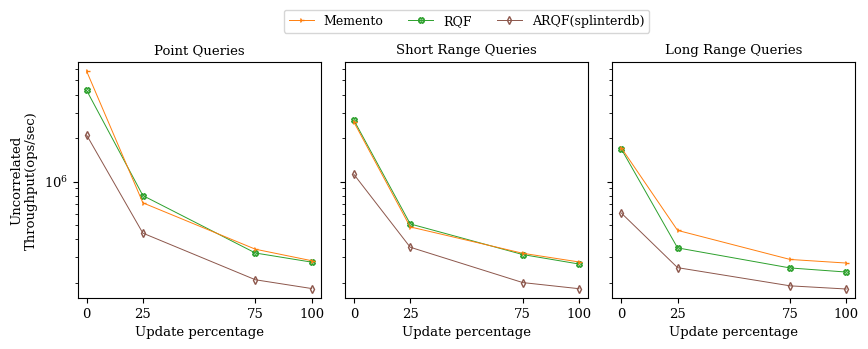

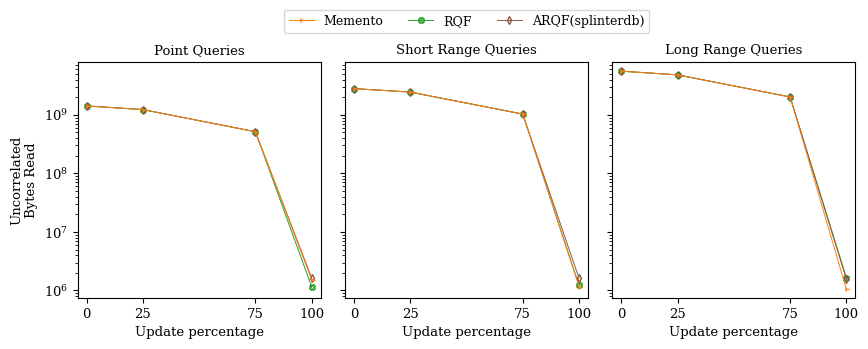

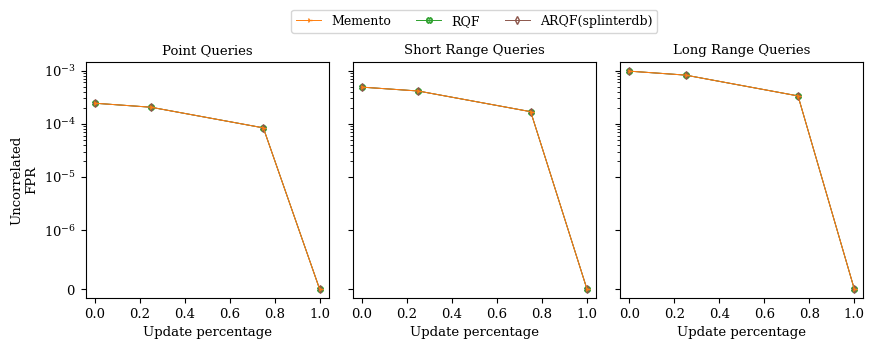

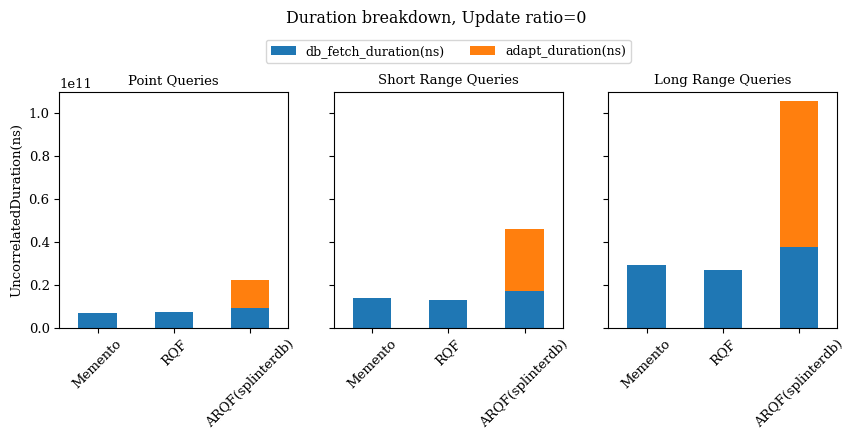

In [19]:
adaptivity_dir = Path('/home/chesetti/Repos/arqf/arqf/workloads/mixed_quniform_allow_true')
plot_mixed_workload(['memento', 'arqf', 'adaptive_arqf_splinterdb'], ['quniform'], 'mixed')
plot_mixed_bytes_read(['memento', 'arqf', 'adaptive_arqf_splinterdb'], ['quniform'], 'mixed')
plot_mixed_fpr(['memento', 'arqf', 'adaptive_arqf_splinterdb'], ['quniform'], 'mixed')
plot_mixed_runtime(['memento', 'arqf', 'adaptive_arqf_splinterdb'], ['quniform'], 'mixed')

[{'Memento': {'adapt_duration(ns)': 284228, 'db_fetch_duration(ns)': 106253808}, 'RQF': {'adapt_duration(ns)': 283280, 'db_fetch_duration(ns)': 110035531}, 'ARQF(splinterdb)': {'adapt_duration(ns)': 66573229, 'db_fetch_duration(ns)': 24992224}}, {'Memento': {'adapt_duration(ns)': 33996, 'db_fetch_duration(ns)': 97188561}, 'RQF': {'adapt_duration(ns)': 32952, 'db_fetch_duration(ns)': 88433247}, 'ARQF(splinterdb)': {'adapt_duration(ns)': 153968708, 'db_fetch_duration(ns)': 47293103}}, {'Memento': {'adapt_duration(ns)': 164599, 'db_fetch_duration(ns)': 148734138}, 'RQF': {'adapt_duration(ns)': 163839, 'db_fetch_duration(ns)': 139721133}, 'ARQF(splinterdb)': {'adapt_duration(ns)': 293304650, 'db_fetch_duration(ns)': 126892315}}]


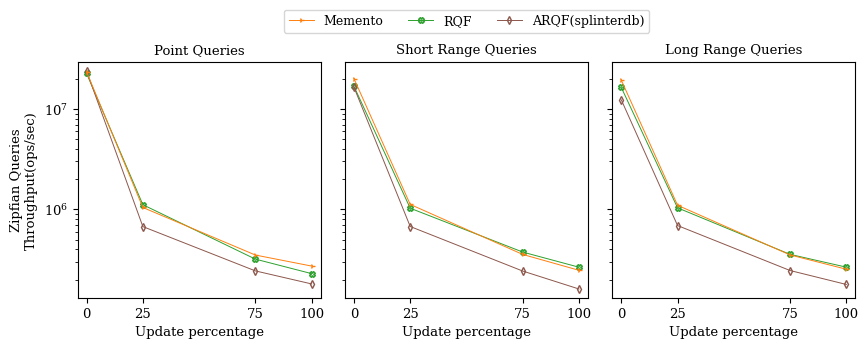

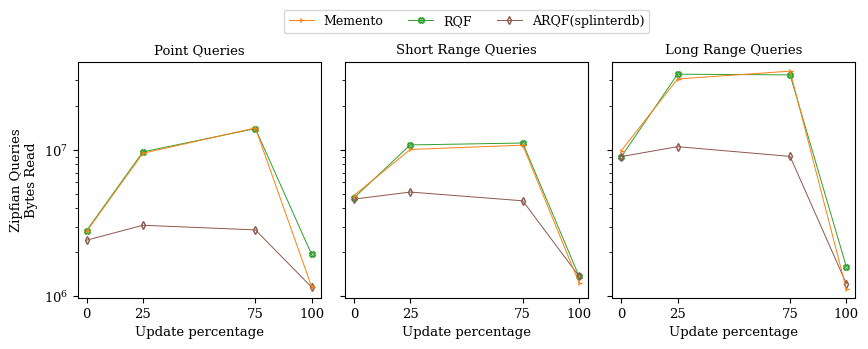

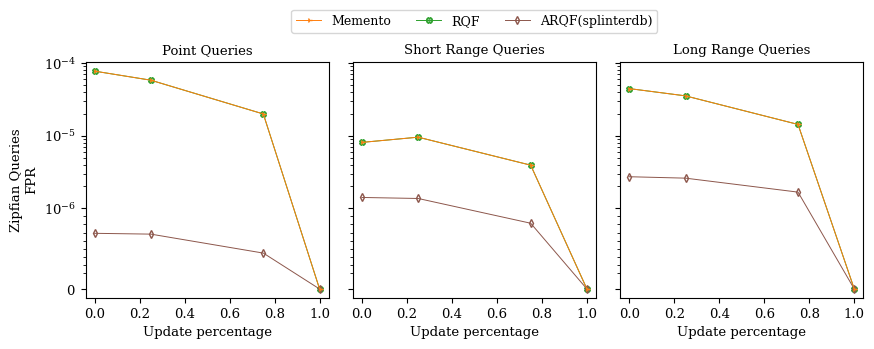

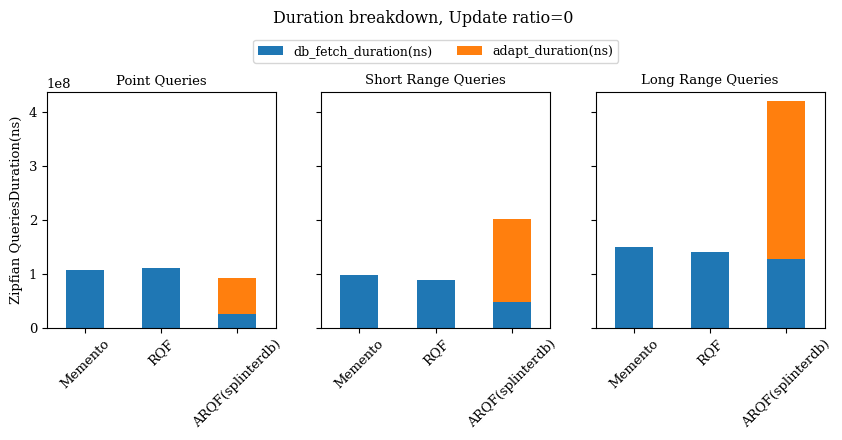

In [20]:
adaptivity_dir = Path('/home/chesetti/Repos/arqf/arqf/workloads/mixed_qzipfian_allow_true')
plot_mixed_workload(['memento', 'arqf', 'adaptive_arqf_splinterdb'], ['qzipfian'], 'mixed')
plot_mixed_bytes_read(['memento', 'arqf', 'adaptive_arqf_splinterdb'], ['qzipfian'], 'mixed')
plot_mixed_fpr(['memento', 'arqf', 'adaptive_arqf_splinterdb'], ['qzipfian'], 'mixed')
plot_mixed_runtime(['memento', 'arqf', 'adaptive_arqf_splinterdb'], ['qzipfian'], 'mixed')

# Adversarial

In [9]:
def plot_adversarial_workload(filters, workloads, name, test_type='adaptivity_disk', ranges=[0,5,10]):
    nrows = 1 # len(workloads)
    ncols = len(ranges)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey='row', figsize=(2 * width * 0.7, 2 * nrows * max_height/6.4))

    iterate = list(itertools.product(workloads, filters, enumerate(ranges)))

    for (x, ds, r) in iterate:
        row = workloads.index(x)
        (idx, ran) = r
        data = pd.read_csv(os.path.join(adaptivity_dir, 'kuniform', f'{r[1]}_{x}_trial_0', f'{ds}_{test_type}.csv'))
        data['fpr_opt'] = data['false_positives'] / data['n_queries']
        data['adversarial_throughput'] = 1000 * data['n_queries'] / data['query_time']
        data['adversarial_rate'] = data['adversarial_rate'] * 100 
        data.plot("adversarial_rate", "adversarial_throughput", ax=axes[idx], **range_filters_style_kwargs[ds], **lines_style)
    
    for ax in axes.flatten():
        ax.set_yscale('symlog', linthresh=(1e-06))
        ax.set_xticks([1, 5, 10])
        ax.set_xlabel('Adversarial percentage', fontsize=xlabel_font_size)
        ax.get_legend().remove()
        ax.autoscale_view()
        ax.margins(0.04)

    for i, k in list(enumerate(workloads)):
        if type(k) is tuple:
            axis_title = f'{labels_name[k[1]]}'
        else:
            axis_title = f'{labels_name[k]}'
        axes[0].set_ylabel(axis_title + "\nThroughput(ops/sec)", fontsize=ylabel_font_size)
        
    for ax in axes:
        ax.yaxis.set_minor_locator(matplotlib.ticker.LogLocator(numticks=10, subs="auto"))
    for i, _ in list(enumerate(query_range)):
        axes[i].set_title(query_range_label[i], fontsize=title_font_size)

    fig.subplots_adjust(wspace=0.1)
    fig.savefig(os.path.join(adaptivity_dir, 'kuniform', f'{name}_nolegend.pdf'), bbox_inches='tight', pad_inches=0.01)
    lines, labels = axes[1].get_legend_handles_labels()

    if len(filters) > 4:
        ncol = (len(filters) + 1) // 2
        bbox = (0.5, 1.65)
    else:
        ncol = len(filters)
        bbox = (0.5, 1.25)

    axes[1].legend(lines, labels, loc='upper center', bbox_to_anchor=bbox, 
            fancybox=True, shadow=False, ncol=ncol, fontsize=9)
    fig.savefig(os.path.join(adaptivity_dir, 'kuniform', f'{name}.pdf'), bbox_inches='tight', pad_inches=0.01)

def plot_adversarial_bytes_read(filters, workloads, name, test_type='adaptivity_disk', ranges=[0,5,10]):
    nrows = 1 # len(workloads)
    ncols = len(ranges)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey='row', figsize=(2 * width * 0.7, 2 * nrows * max_height/6.4))

    iterate = list(itertools.product(workloads, filters, enumerate(ranges)))

    for (x, ds, r) in iterate:
        row = workloads.index(x)
        (idx, ran) = r
        data = pd.read_csv(os.path.join(adaptivity_dir, 'kuniform', f'{r[1]}_{x}_trial_0', f'{ds}_{test_type}.csv'))
        data['fpr_opt'] = data['false_positives'] / data['n_queries']
        data['adversarial_rate'] = data['adversarial_rate'] * 100 
        data.plot("adversarial_rate", "bytes_read", ax=axes[idx], **range_filters_style_kwargs[ds], **lines_style)
    
    for ax in axes.flatten():
        ax.set_yscale('symlog', linthresh=(1e-06))
        ax.set_xticks([1, 5, 10])
        ax.set_xlabel('Adversarial percentage', fontsize=xlabel_font_size)
        ax.get_legend().remove()
        ax.autoscale_view()
        ax.margins(0.04)

    for i, k in list(enumerate(workloads)):
        if type(k) is tuple:
            axis_title = f'{labels_name[k[1]]}'
        else:
            axis_title = f'{labels_name[k]}'
        axes[0].set_ylabel(axis_title + "\nBytes fetched from disk", fontsize=ylabel_font_size)
        
    for ax in axes:
        ax.yaxis.set_minor_locator(matplotlib.ticker.LogLocator(numticks=10, subs="auto"))
    for i, _ in list(enumerate(query_range)):
        axes[i].set_title(query_range_label[i], fontsize=title_font_size)

    fig.subplots_adjust(wspace=0.1)
    fig.savefig(os.path.join(adaptivity_dir, 'kuniform', f'{name}_nolegend.pdf'), bbox_inches='tight', pad_inches=0.01)
    lines, labels = axes[1].get_legend_handles_labels()

    if len(filters) > 4:
        ncol = (len(filters) + 1) // 2
        bbox = (0.5, 1.65)
    else:
        ncol = len(filters)
        bbox = (0.5, 1.25)

    axes[1].legend(lines, labels, loc='upper center', bbox_to_anchor=bbox, 
            fancybox=True, shadow=False, ncol=ncol, fontsize=9)
    fig.savefig(os.path.join(adaptivity_dir, 'kuniform', f'{name}.pdf'), bbox_inches='tight', pad_inches=0.01)


def plot_adversarial_fpr(filters, workloads, name, test_type='adaptivity_disk', ranges=[0,5,10]):
    nrows = 1 # len(workloads)
    ncols = len(ranges)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey='row', figsize=(2 * width * 0.7, 2 * nrows * max_height/6.4))

    iterate = list(itertools.product(workloads, filters, enumerate(ranges)))

    for (x, ds, r) in iterate:
        row = workloads.index(x)
        (idx, ran) = r
        print(os.path.join(adaptivity_dir, 'kuniform', f'{r[1]}_{x}_trial_0', f'{ds}_{test_type}.csv'))
        data = pd.read_csv(os.path.join(adaptivity_dir, 'kuniform', f'{r[1]}_{x}_trial_0', f'{ds}_{test_type}.csv'))
        data['fpr_opt'] = data['false_positives'] / data['n_queries']
        data['adversarial_rate'] = data['adversarial_rate'] * 100 
        data.plot("adversarial_rate", "fpr_opt", ax=axes[idx], **range_filters_style_kwargs[ds], **lines_style)
    
    for ax in axes.flatten():
        ax.set_yscale('symlog', linthresh=(1e-06))
        ax.set_xticks([1, 5, 10])
        ax.set_xlabel('Adversarial percentage', fontsize=xlabel_font_size)
        ax.get_legend().remove()
        ax.autoscale_view()
        ax.margins(0.04)

    for i, k in list(enumerate(workloads)):
        if type(k) is tuple:
            axis_title = f'{labels_name[k[1]]}'
        else:
            axis_title = f'{labels_name[k]}'
        axes[0].set_ylabel(axis_title + "\nFPR", fontsize=ylabel_font_size)
        
    for ax in axes:
        ax.yaxis.set_minor_locator(matplotlib.ticker.LogLocator(numticks=10, subs="auto"))
    for i, _ in list(enumerate(query_range)):
        axes[i].set_title(query_range_label[i], fontsize=title_font_size)

    fig.subplots_adjust(wspace=0.1)
    fig.savefig(os.path.join(adaptivity_dir, 'kuniform', f'{name}_nolegend.pdf'), bbox_inches='tight', pad_inches=0.01)
    lines, labels = axes[1].get_legend_handles_labels()

    if len(filters) > 4:
        ncol = (len(filters) + 1) // 2
        bbox = (0.5, 1.65)
    else:
        ncol = len(filters)
        bbox = (0.5, 1.25)

    axes[1].legend(lines, labels, loc='upper center', bbox_to_anchor=bbox, 
            fancybox=True, shadow=False, ncol=ncol, fontsize=9)
    fig.savefig(os.path.join(adaptivity_dir, 'kuniform', f'{name}.pdf'), bbox_inches='tight', pad_inches=0.01)

def plot_adversarial_runtime(filters, workloads, name, test_type='adaptivity_disk', adversarial_rate=10, ranges=[0,5,10]):
    nrows = 1 # len(workloads)
    ncols = len(ranges)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey='row', figsize=(2 * width * 0.7, 2 * nrows * max_height/6.4))

    iterate = list(itertools.product(workloads, filters, enumerate(ranges)))

    query_times = [{}, {}, {}]

    for (x, ds, r) in iterate:
        row = workloads.index(x)
        (idx, ran) = r
        data = pd.read_csv(os.path.join(adaptivity_dir, 'kuniform', f'{r[1]}_{x}_trial_0', f'{ds}_{test_type}.csv'))
        data['fpr_opt'] = data['false_positives'] / data['n_queries']
        data['adversarial_rate'] = data['adversarial_rate'] * 100 
        query_times[idx][range_filters_style_kwargs[ds]['label']] = {
            'adapt_duration(ns)': data[data['adversarial_rate'] == adversarial_rate]['adapt_duration_ns'].values[0],
            'db_fetch_duration(ns)': data[data['adversarial_rate'] == adversarial_rate]['db_fetch_duration_ns'].values[0]
        }

    for idx in range(0, 3):
        df = pd.DataFrame.from_dict(query_times[idx], orient='index')
        df.plot.bar(stacked=True, ax=axes[idx], title=f'')

    for ax in axes.flatten():
        #ax.set_yscale('symlog', linthresh=(1e-06))
        ax.get_legend().remove()
        ax.autoscale_view()
        ax.margins(0.04)
        ax.tick_params(axis='x', labelrotation=45)

    for i, k in list(enumerate(workloads)):
        if type(k) is tuple:
            axis_title = f'{labels_name[k[1]]}'
        else:
            axis_title = f'{labels_name[k]}'
        axes[0].set_ylabel(axis_title + "Duration(ns)", fontsize=ylabel_font_size)

    for i, _ in list(enumerate(query_range)):
        axes[i].set_title(query_range_label[i], fontsize=title_font_size)

    lines, labels = axes[1].get_legend_handles_labels()
    if len(filters) > 4:
        ncol = (len(filters) + 1) // 2
        bbox = (0.5, 1.65)
    else:
        ncol = len(filters)
        bbox = (0.5, 1.25)
    axes[1].legend(lines, labels, loc='upper center', bbox_to_anchor=bbox, 
            fancybox=True, shadow=False, ncol=ncol, fontsize=9)
    fig.suptitle(f'Duration breakdown, Adversarial Percentage={adversarial_rate}', y=1.15)
    
    print(query_times)

/home/chesetti/Repos/arqf/arqf/workloads/adversarial/kuniform/0_quniform_trial_0/memento_adaptivity_disk.csv
/home/chesetti/Repos/arqf/arqf/workloads/adversarial/kuniform/5_quniform_trial_0/memento_adaptivity_disk.csv
/home/chesetti/Repos/arqf/arqf/workloads/adversarial/kuniform/10_quniform_trial_0/memento_adaptivity_disk.csv
/home/chesetti/Repos/arqf/arqf/workloads/adversarial/kuniform/0_quniform_trial_0/arqf_adaptivity_disk.csv
/home/chesetti/Repos/arqf/arqf/workloads/adversarial/kuniform/5_quniform_trial_0/arqf_adaptivity_disk.csv
/home/chesetti/Repos/arqf/arqf/workloads/adversarial/kuniform/10_quniform_trial_0/arqf_adaptivity_disk.csv
/home/chesetti/Repos/arqf/arqf/workloads/adversarial/kuniform/0_quniform_trial_0/adaptive_arqf_splinterdb_adaptivity_disk.csv
/home/chesetti/Repos/arqf/arqf/workloads/adversarial/kuniform/5_quniform_trial_0/adaptive_arqf_splinterdb_adaptivity_disk.csv
/home/chesetti/Repos/arqf/arqf/workloads/adversarial/kuniform/10_quniform_trial_0/adaptive_arqf_splin

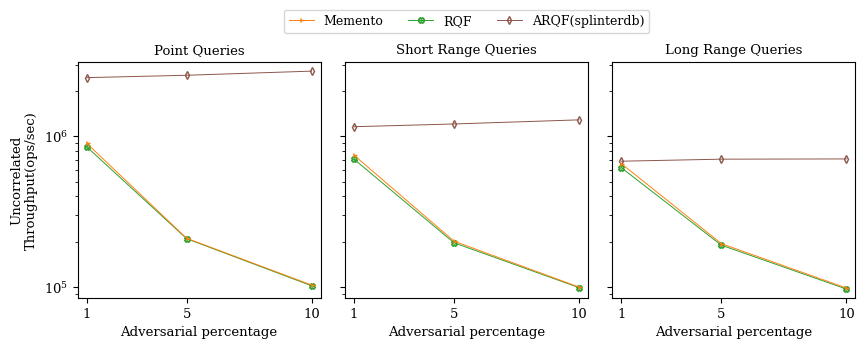

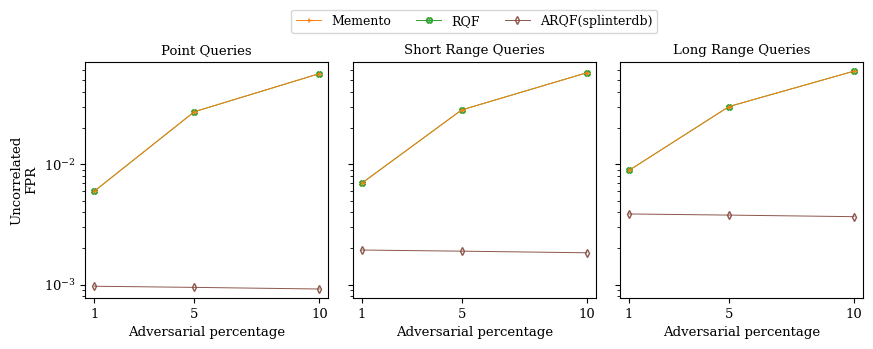

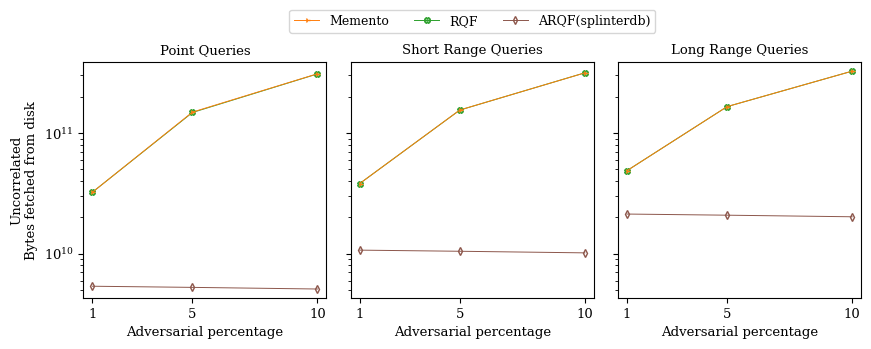

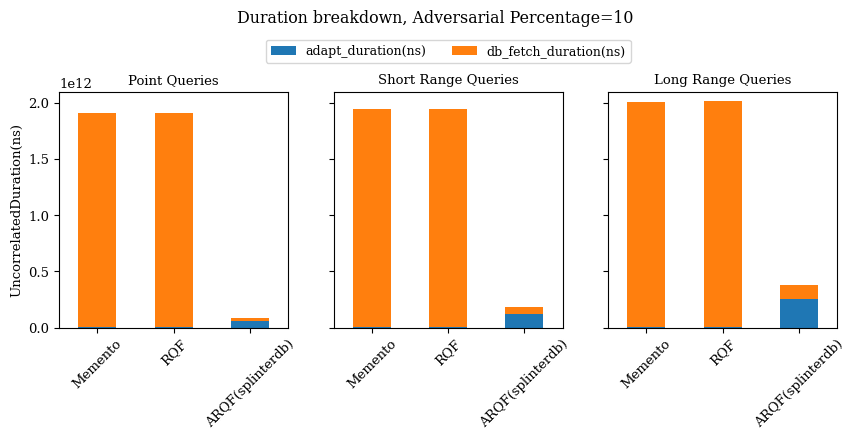

In [11]:
adaptivity_dir = Path('/home/chesetti/Repos/arqf/arqf/workloads/adversarial')
plot_adversarial_workload(['memento', 'arqf', 'adaptive_arqf_splinterdb'], ['quniform'], 'adversarial')
plot_adversarial_fpr(['memento', 'arqf', 'adaptive_arqf_splinterdb'], ['quniform'], 'adversarial')
plot_adversarial_bytes_read(['memento', 'arqf', 'adaptive_arqf_splinterdb'], ['quniform'], 'adversarial')
plot_adversarial_runtime(['memento', 'arqf', 'adaptive_arqf_splinterdb'], ['quniform'], 'adversarial')

In [47]:
def print_splinter_cache_vs_insert(filters, workloads, name, test_type='adaptivity_mixed', ranges=[0,5,10]):
    iterate = list(itertools.product(workloads, filters, enumerate(ranges)))

    for (x, ds, r) in iterate:
        row = workloads.index(x)
        (idx, ran) = r
        data = pd.read_csv(os.path.join(adaptivity_dir, 'kuniform', f'{r[1]}_{x}_trial_0', f'{ds}_{test_type}.csv'))
        data = data.loc[['read_ratio']]
        rhm = data.pivot_table(index='splinter_cache_mb', values=['rhm_insert_latency_min', 'rhm_insert_latency_median', 'rhm_insert_latency_99p', 'rhm_insert_latency_max'], aggfunc='mean')
        qf = data.pivot_table(index='splinter_cache_mb', values=['qf_insert_latency_min', 'qf_insert_latency_median', 'qf_insert_latency_99p', 'qf_insert_latency_max'], aggfunc='mean')
        display(rhm[['rhm_insert_latency_min', 'rhm_insert_latency_median', 'rhm_insert_latency_99p', 'rhm_insert_latency_max']])
        display(qf[['qf_insert_latency_min', 'qf_insert_latency_median', 'qf_insert_latency_99p', 'qf_insert_latency_max']])

In [48]:
adaptivity_dir = Path('/home/chesetti/Repos/arqf/arqf/workloads/performance_medium')
print_splinter_cache_vs_insert(['adaptive_arqf_splinterdb'], ['quniform'], "insert_breakdown", ranges=[0])

,rhm_insert_latency_min,rhm_insert_latency_median,rhm_insert_latency_99p,rhm_insert_latency_max
splinter_cache_mb,,,,
64,207.333333,786.000000,2317.666667,8.859760e+08
256,213.000000,784.666667,2432.000000,8.806601e+08
1024,210.333333,793.000000,2991.666667,5.280374e+08


,qf_insert_latency_min,qf_insert_latency_median,qf_insert_latency_99p,qf_insert_latency_max
splinter_cache_mb,,,,
64,48.333333,223.000000,851.000000,4.208682e+06
256,48.000000,211.333333,790.333333,3.193827e+06
1024,49.000000,208.666667,831.333333,2.831409e+06


## Memory vs. FPR

In [37]:
sorted_dirs = sorted(os.listdir(fpr_test_path), reverse=True)
if len(sorted_dirs) < 1:
    raise FileNotFoundError(
        "error, cannot find the latest test executed")

fpr_test_path = Path(fpr_test_path + '/' + sorted_dirs[0])
print(str(fpr_test_path))

/home/chesetti/Repos/arqf/arqf/paper_results/results/fpr_test/2024-09-01.08:14:33


In [38]:
fpr_real_test_path = f'{base_csv_path}/fpr_real_test'

sorted_dirs = sorted(os.listdir(fpr_real_test_path), reverse=True)
if len(sorted_dirs) < 1:
    raise FileNotFoundError(
        "error, cannot find the latest test executed")

fpr_real_test_path = Path(fpr_real_test_path + '/' + sorted_dirs[1])

FileNotFoundError: [Errno 2] No such file or directory: '/home/chesetti/Repos/arqf/arqf/paper_results/results/fpr_real_test'

In [ ]:
def print_fpr_test(filters, workloads, name):
    nrows = len(workloads)
    ncols = len(query_range)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey='row', figsize=(width * 0.7, max_height/1.6))

    iterate = list(itertools.product(workloads, filters, enumerate(query_range)))

    for (x, ds, r) in iterate:
        row = workloads.index(x)
        (idx, ran) = r
        if type(x) is tuple:
            data = pd.read_csv(get_file(ds, r[1], x[0], x[1], path=fpr_test_path))
        else:
            data = pd.read_csv(get_file(ds, r[1], x, path=fpr_real_test_path))
        data['fpr_opt'] = data['false_positives'] / data['n_queries']
        data.plot("bpk", "fpr_opt", ax=axes[row][idx], **range_filters_style_kwargs[ds], **lines_style)

    ticks = [1, 1e-01, 1e-02, 1e-03, 1e-04, 1e-05, 1e-06, 0]

    for ax in axes.flatten():
        ax.set_yscale('symlog', linthresh=(1e-06))
        ax.set_xlim(right=max_x_axis_bpk)
        ax.set_yticks(ticks)
        ax.set_ylim(bottom=-0.0000003, top=1.9)
        ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(2))
        ax.set_xlabel('Space [bits/key]', fontsize=xlabel_font_size)
        ax.get_legend().remove()
        ax.autoscale_view()
        ax.margins(0.04)
    
    for ax in axes:
        ax[0].yaxis.set_minor_locator(matplotlib.ticker.LogLocator(numticks=10, subs="auto"))
        
    for i, k in list(enumerate(workloads)):
        if type(k) is tuple:
            axis_title = f'{labels_name[k[1]]}'
        else:
            axis_title = f'{labels_name[k]}'
        axes[i][0].set_ylabel(axis_title + "\nFPR", fontsize=ylabel_font_size)
        
    for i, _ in list(enumerate(query_range)):
        axes[0][i].set_title(query_range_label[i], fontsize=title_font_size)

    fig.subplots_adjust(wspace=0.1)
    fig.savefig(f'{out_folder}/fpr_test_{name}_nolegend.pdf', bbox_inches='tight', pad_inches=0.01)
    lines, labels = axes[0][1].get_legend_handles_labels()

    if len(filters) > 4:
        ncol = (len(filters) + 1) // 2
        bbox = (0.5, 1.65)
    else:
        ncol = len(filters)
        bbox = (0.5, 1.5)
        
    axes[0][1].legend(lines, labels, loc='upper center', bbox_to_anchor=bbox,
            fancybox=True, shadow=False, ncol=ncol, fontsize=legend_font_size)
    fig.savefig(f'{out_folder}/fpr_test_{name}.pdf', bbox_inches='tight', pad_inches=0.01)

In [ ]:
import collections

def generate_tables(filters, workloads):
    nrows = len(workloads)
    workload_row = [collections.defaultdict(list) for _ in range(nrows)]
    iterate = list(itertools.product(workloads, filters, enumerate(query_range)))

    for (x, ds, r) in iterate:
        row = workloads.index(x)
        if type(x) is tuple:
            data = pd.read_csv(get_file(ds, r[1], x[0], x[1], path=fpr_test_path))
        else:
            data = pd.read_csv(get_file(ds, r[1], x, path=fpr_real_test_path))
        data["single_query_time"] = (data["query_time"] / data["n_queries"]) * 10**6
        workload_row[row][ds].append(round(data["single_query_time"].mean(), 2))

    mean_row = [collections.defaultdict(list) for _ in range(nrows)]
    for i in range(nrows):
        for key, value in workload_row[i].items():
            mean_row[i][key].append(round(np.mean(value)))
        default_value = mean_row[i][filters[0]][0]
        for key, value in mean_row[i].items():
            mean_row[i][key].append(round(value[0]/default_value, 2))

    df_list = []
    for i in range(nrows): 
        df = pd.DataFrame()
        df['Competitor'] = mean_row[i].keys()
        df['idx'] = df['Competitor'].copy()
        df = df.set_index('idx')
        for key, value in mean_row[i].items():
            col_name = 'Avg Query time (wrt ' + filters[0] + ')'
            df.at[key, 'avg'] = value[0]
            df.at[key, col_name] = str(value[0]) + ' (' + str(value[1]) + '\\times)'

        # sort by 'temp' column ignoring the row of index 'Grafite'
        df.iat[0, df.columns.get_loc('avg')] = -1
        df = df.sort_values(by=['avg'])
        # remove the 'temp' column
        df = df.drop('avg', axis=1)
        df_list.append(df)
        
    return df_list

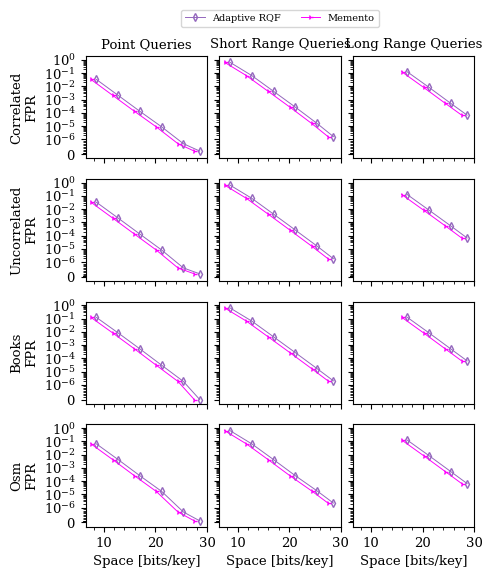

In [ ]:

workloads = [('kuniform', 'qcorrelated') , ('kuniform', 'quniform'), ('books'), ('osm')]
range_filters = ['arqf', 'memento'] #, 'proteus', 'snarf', 'rencoder', 'rosetta']

print_fpr_test(range_filters, workloads, 'all')

In [ ]:
df_list = generate_tables(range_filters, workloads)
with open(f'{out_folder}/table.tex', 'w') as f:
    for df in df_list:
        f.write(df.to_latex(index=False))
        f.write("\n\n")

## Input Size vs Construction Time

In [ ]:
size_test_path = f'{base_csv_path}/constr_time_test'

sorted_dirs = sorted(os.listdir(size_test_path), reverse=True)
if len(sorted_dirs) < 1:
    raise FileNotFoundError(
        "error, cannot find the latest test executed")

size_test_path = Path(size_test_path + '/' + sorted_dirs[0])

keys_size = [5, 6, 7, 8]
labels_keys_size = [f'$10^{x}$' for x in keys_size]

matplotlib.rcParams['hatch.linewidth'] = 0.1

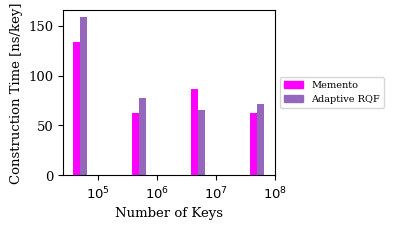

In [ ]:
old_range_filters = range_filters
range_filters = ['memento',  'arqf'] #'snarf', 'surf', 'proteus', 'rosetta', 'rencoder']
range_filter_labels = ['Memento', 'Grafite', 'SNARF', 'SuRF', 'Proteus', 'Rosetta', 'REncoder']

fig, ax = plt.subplots(figsize=(width_small * 0.78, 0.3 * width))

width_bars = 0.12  # Width of the bars
multiplier = 0

iterate = list(itertools.product(keys_size, range_filters))
for (r, ds) in iterate:
    i = r - min(keys_size)
    data = pd.read_csv(get_file(ds, 5, f'kuniform_{r}', query_name='quniform', path=size_test_path))
    if data.empty or data["build_time"].empty: continue

    if "modelling_time" in data.columns:
        build_time = np.mean(data['build_time'])/data['n_keys'] * 10**6
        modelling_time = np.mean(data['modelling_time'])/data['n_keys'] * 10**6
        ax.bar(range_filters.index(ds) * width_bars + i, build_time, width_bars, color=range_filters_style_kwargs[ds]['color'])
        ax.bar(range_filters.index(ds) * width_bars + i, modelling_time, width_bars, label='_nolegend_', bottom=build_time, color=range_filters_style_kwargs[ds]['color'], alpha=0.1, hatch='//////')
    else:
        build_time = np.mean(data['build_time'])/data['n_keys'] * 10**6
        ax.bar(range_filters.index(ds) * width_bars + i, build_time, width_bars, color=range_filters_style_kwargs[ds]['color'])

ax.set_ylabel('Construction Time [ns/key]', fontsize=ylabel_font_size)
ax.legend([range_filters_style_kwargs[ds]['label'] for ds in range_filters], loc='center left', bbox_to_anchor=(1, 0.5),
                  fancybox=True, shadow=False, ncol=1, fontsize=legend_font_size)
ax.set_xticks(np.arange(len(keys_size)) + 3 * width_bars, labels_keys_size)
ax.set_xlabel('Number of Keys', fontsize=xlabel_font_size)
ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(100))

leg = ax.get_legend()
for ds, label in zip(range_filters, range_filter_labels):
    leg.legend_handles[range_filters.index(ds)].set_color(range_filters_style_kwargs[ds]['color'])

fig.savefig(f'{out_folder}/constr_time_test.pdf', bbox_inches='tight', pad_inches=0.01)
range_filters = old_range_filters

## Memory vs. Query Time (Non-Empty Queries)

In [ ]:
true_test_path = f'{base_csv_path}/true_test'

sorted_dirs = sorted(os.listdir(true_test_path), reverse=True)
if len(sorted_dirs) < 1:
    raise FileNotFoundError(
        "error, cannot find the latest test executed")

true_test_path = Path(true_test_path + '/' + sorted_dirs[0])

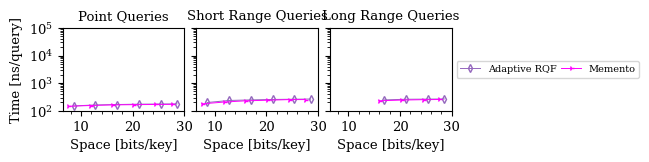

In [ ]:
keys_synth = ['kuniform']
nrows = len(keys_synth)
ncols = len(query_range)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey='row', figsize=(width * 0.7, 0.15 * width))

iterate = list(itertools.product(range_filters, enumerate(query_range)))

for (ds, r) in iterate:
    (idx, ran) = r
    data = pd.read_csv(get_file(ds, r[1], 'kuniform', 'qtrue', true_test_path))
    data["single_query_time"] = (data["query_time"] / data["n_queries"]) * 10**6
    data.plot("bpk", "single_query_time", ax=axes[idx], **range_filters_style_kwargs[ds], **lines_style)

ticks = [10**2, 10**3, 10**4, 10**5]

for ax in axes.flatten():
    ax.set_xlim(right=max_x_axis_bpk)
    ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(2))
    ax.set_xlabel('Space [bits/key]', fontsize=xlabel_font_size)
    ax.set_yscale('log')
    ax.get_legend().remove()
    ax.yaxis.set_minor_locator(matplotlib.ticker.LogLocator(numticks=10, subs='auto'))
    ax.set_yticks(ticks)

for i, k in list(enumerate(keys_synth)):
    axis_title = f'{k}'
    axes[i].set_ylabel("Time [ns/query]", fontsize=ylabel_font_size)
    
for i, _ in list(enumerate(query_range)):
    axes[i].set_title(query_range_label[i], fontsize=title_font_size)
    
fig.subplots_adjust(wspace=0.1)
fig.savefig(f'{out_folder}/true_queries_test_nolegend.pdf', bbox_inches='tight', pad_inches=0.01)
box = axes[2].get_position()
lines, labels = axes[0].get_legend_handles_labels()
# order = [0,1,5,2,6,3,7,4,8]
axes[2].legend(lines, labels, 
                  loc='center left', bbox_to_anchor=(1, 0.5),
                  fancybox=True, shadow=False, ncol=2, fontsize=legend_font_size, columnspacing=0.5)

fig.savefig(f'{out_folder}/true_queries_test.pdf', bbox_inches='tight', pad_inches=0.01)

## Correlation vs. FPR

In [ ]:
corr_test_path = f'{base_csv_path}/corr_test'

sorted_dirs = sorted(os.listdir(corr_test_path), reverse=True)
if len(sorted_dirs) < 1:
    raise FileNotFoundError(
        "error, cannot find the latest test executed")

corr_test_path = Path(corr_test_path + '/' + sorted_dirs[0])

corr_degrees = range(0, 11)

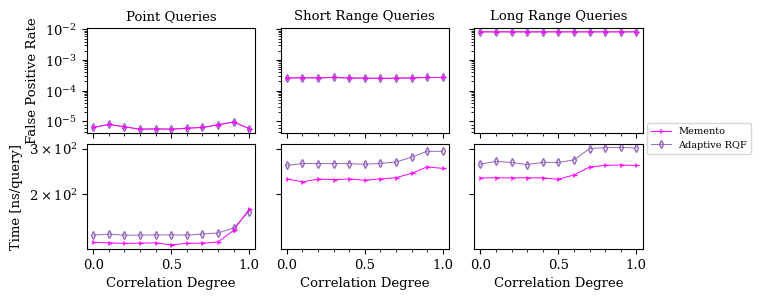

In [ ]:
from matplotlib.ticker import AutoLocator

fig, axes = plt.subplots(2, 3, sharex=True, sharey='row', figsize=(width, 0.4 * width))

range_filters_corr = ['memento',  'arqf']

iterate = list(itertools.product(range_filters_corr, enumerate(query_range), corr_degrees))

values = [dict() for x in range(len(query_range))]
time_values = [dict() for x in range(len(query_range))]

for ds in range_filters_corr:
    for r in range(len(query_range)):
        values[r][ds] = []
        time_values[r][ds] = []
        
xlabels_corr = [ x/10 for x in corr_degrees ]

for (ds, r, deg) in iterate:
    (idx, ran) = r
    data = pd.read_csv(get_file(ds, r[1], f'kuniform_{deg}', 'qcorrelated', corr_test_path))
    data['fpr_opt'] = data['false_positives'] / data['n_queries']
    fpr = data['fpr_opt'][0]
    time = data['query_time'][0]/data['n_queries'][0] * 10**6
    values[idx][ds].append(fpr)
    time_values[idx][ds].append(time)
    
for r in range(len(query_range)):
    for key, data_list in values[r].items():
        axes[0][r].plot(xlabels_corr, data_list, **range_filters_style_kwargs[key], **lines_style)
            
for r in range(len(query_range)):
    for key, data_list in time_values[r].items():
        axes[1][r].plot(xlabels_corr, data_list, **range_filters_style_kwargs[key], **lines_style)   
    axes[1][r].set_yscale('log')
    
axes[1][0].set_ylabel('Time [ns/query]', fontsize=ylabel_font_size)

for ax in axes.flatten():
    ax.margins(0.04)
    ax.set_yscale('symlog', linthresh=(1e-05))
    ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(0.1))
    
for ax in axes[1].flatten():
    ax.set_xlabel('Correlation Degree', fontsize=xlabel_font_size)
    ax.yaxis.set_major_locator(AutoLocator())  # solution
    ax.yaxis.set_minor_locator(matplotlib.ticker.LogLocator(numticks=10, subs='auto'))
    
for i, _ in list(enumerate(query_range)):
    axes[0][i].set_title(query_range_label[i], fontsize=xlabel_font_size)
plt.subplots_adjust(hspace=0.1, wspace=0.15)
axes[0][0].set_ylabel('False Positive Rate', fontsize=ylabel_font_size)
axes[0][0].yaxis.set_minor_locator(matplotlib.ticker.LogLocator(numticks=10, subs='auto'))

plt.savefig(f'{out_folder}/corr_test_twolines_nolegend.pdf', bbox_inches='tight', pad_inches=0.01)
box = axes[0][2].get_position()
lines, labels = axes[0][0].get_legend_handles_labels()
# order = [0,4,1,5,2,6,3,4]
order = list(range(len(range_filters_corr)))
axes[0][2].legend([lines[idx] for idx in order],[labels[idx] for idx in order], 
                  loc='center left', bbox_to_anchor=(1, -0.05),
                  fancybox=True, shadow=False, ncol=1, fontsize=legend_font_size)

plt.savefig(f'{out_folder}/corr_test_twolines.pdf', bbox_inches='tight', pad_inches=0.01)

## Correlation (Small)

FileNotFoundError: [Errno 2] No such file or directory: '/home/chesetti/Repos/arqf/arqf/paper_results/results/corr_test/2024-08-01.13:55:53/kuniform_0/5_qcorrelated/grafite.csv'

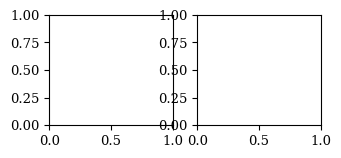

In [ ]:
range_filters_corr = ['memento', 'grafite', 'arqf'] #, 'surf', 'proteus', 'rosetta', 'rencoder']

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(width_small, 0.2 * width))
query_range_small = [5]

iterate = list(itertools.product(range_filters_corr, enumerate(query_range_small), corr_degrees))
values = [dict() for x in range(len(query_range_small))]
time_values = [dict() for x in range(len(query_range_small))]

for ds in range_filters_corr:
    for r in range(len(query_range_small)):
        values[r][ds] = []
        time_values[r][ds] = []
        
xlabels_corr = [ x/10 for x in corr_degrees ]

for (ds, r, deg) in iterate:
    (idx, ran) = r
    data = pd.read_csv(get_file(ds, r[1], f'kuniform_{deg}', 'qcorrelated', corr_test_path))
    data['fpr_opt'] = data['false_positives'] / data['n_queries']
    fpr = data['fpr'][0]
    time = data['query_time'][0]/data['n_queries'][0] * 10**6
    values[idx][ds].append(fpr)
    time_values[idx][ds].append(time)
    
for key, data_list in values[0].items():
    axes[0].plot(xlabels_corr, data_list, **range_filters_style_kwargs[key], **lines_style)
            
for key, data_list in time_values[0].items():
    axes[1].plot(xlabels_corr, data_list, **range_filters_style_kwargs[key], **lines_style)   
axes[1].set_yscale('log')

axes[1].set_ylabel('Time [ns/query]', fontsize=ylabel_font_size)
axes[1].set_ylim(10**2, 10**4)

for ax in axes.flatten():
    ax.set_yscale('log')
    ax.set_xlabel('Correlation Degree', fontsize=xlabel_font_size)
    ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(0.1))
    ax.set_xticks([0, 0.5, 1])

box = axes[1].get_position()
lines, labels = axes[0].get_legend_handles_labels()
lines2, labels2 = axes[1].get_legend_handles_labels()
axes[1].xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%g'))
axes[1].legend(lines, labels, loc='upper center', bbox_to_anchor=(-0.3, -0.4),
          fancybox=True, shadow=False, ncol=3, columnspacing=0.5, fontsize=legend_font_size)
axes[0].set_ylabel('False Positive Rate', fontsize=ylabel_font_size)
axes[0].yaxis.set_minor_locator(matplotlib.ticker.LogLocator(numticks=10, subs='auto'))
axes[0].set_yticks([1, 1e-01, 1e-02, 1e-03, 1e-04])
fig.align_ylabels([axes[0], axes[1]])

plt.subplots_adjust(wspace=0.5)
plt.savefig(f'{out_folder}/corr_test_small.pdf', bbox_inches='tight', pad_inches=0.01)

## Expandability

In [ ]:
expansion_test_path = f'{base_csv_path}/expansion_test'

sorted_dirs = sorted(os.listdir(expansion_test_path), reverse=True)
if len(sorted_dirs) < 1:
    raise FileNotFoundError(
        "error, cannot find the latest test executed")

expansion_test_path = Path(expansion_test_path + '/' + sorted_dirs[0])

corr_degrees = range(0, 2)
N_EXPANSIONS = 7

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(1 * width, 0.19 * width))
axes = fig.axes

fpr_insert_sep = matplotlib.lines.Line2D((0.7125, 0.7125), (0.91, 0.07), linestyle="--", color="lightgrey",
                                         transform=fig.transFigure)
fig.lines = fpr_insert_sep,

range_filters_exp = ['memento', 'snarf', 'rosetta', 'rencoder']

alt_lines_style = {'markersize': 4, 'linewidth': 0.7, 'fillstyle': 'none', 'linestyle': "-."}

exp_query_range = query_range
iterate = list(itertools.product(range_filters_exp, enumerate(exp_query_range), corr_degrees))
xlabels_expansion = [i for i in range(N_EXPANSIONS + 1)]

values = [[collections.defaultdict(list) for x in range(len(exp_query_range))] for corr_degree in corr_degrees]
exp_times = [[collections.defaultdict(list) for x in range(len(exp_query_range))] for corr_degree in corr_degrees]

for (ds, r, deg) in iterate:
    (idx, ran) = r
    data = pd.read_csv(get_file(ds, ran, f'kuniform_{deg}', 'qcorrelated', expansion_test_path))
    for i in range(N_EXPANSIONS):
        if f"false_positives_{i}" in data:
            values[deg][idx][ds].append(data[f"false_positives_{i}"] / data[f"n_queries_{i}"])
        if f"expansion_time_{i}" in data and f"n_keys_{i}" in data:
            exp_times[deg][idx][ds].append(data[f"expansion_time_{i}"] / (data[f"n_keys_{i}"] / 2) * 10 ** 6)

for deg in corr_degrees:
    for r in range(len(exp_query_range)):
        for key, data_list in values[deg][r].items():
            axes[r].plot(xlabels_expansion[:len(data_list)], data_list, **range_filters_style_kwargs[key], **(lines_style if deg == 0 else alt_lines_style))
for deg in corr_degrees:
    for key, data_list in exp_times[deg][0].items():
        axes[-1].plot(xlabels_expansion[1:len(data_list) + 1], data_list, **range_filters_style_kwargs[key], **(lines_style if deg == 0 else alt_lines_style))

for ax in axes:
    ax.margins(0.04)
    ax.set_yscale('symlog', linthresh=(1e-05))
    ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1))
for ax in axes[1:3]:
    ax.set_ylim(axes[0].get_ylim())
    ax.set_yticklabels([])
axes[-1].set_yscale('symlog', linthresh=(1e02))
axes[-1].yaxis.set_label_position("right")
axes[-1].yaxis.tick_right()

for i, _ in list(enumerate(exp_query_range)):
    axes[i].set_title(query_range_label[i], fontsize=xlabel_font_size)
axes[-1].set_title("Inserts", fontsize=xlabel_font_size)
plt.subplots_adjust(hspace=0.1, wspace=0.15)

axes[0].set_ylabel('False Positive Rate', fontsize=ylabel_font_size)
axes[-1].set_ylabel('Time [ns/insert]', fontsize=ylabel_font_size)
for ax in axes:
    ax.yaxis.set_minor_locator(matplotlib.ticker.LogLocator(numticks=10, subs='auto'))

for i in range(len(exp_query_range) + 1):
    axes[i].set_xlabel('Number of Expansions', fontsize=ylabel_font_size)
    axes[i].set_xticks([0, 2, 4, 6])

plt.savefig(f'{out_folder}/expansion_test_nolegend.pdf', bbox_inches='tight', pad_inches=0.01)
box = axes[-1].get_position()
lines, labels = axes[0].get_legend_handles_labels()
# order = [0,4,1,5,2,6,3,4]
order = list(range(len(range_filters_exp)))
legend_lines = [mlines.Line2D([], [], color='black', linestyle="-."),
                mlines.Line2D([], [], color='black', linestyle="-")]
legend_line_labels = ["\\textsc{Correlated} (0.2)", "\\textsc{Uncorrelated}"]
axes[-1].legend([lines[idx] for idx in order] + legend_lines, [labels[idx] for idx in order] + legend_line_labels, 
                loc='center left', bbox_to_anchor=(1.4, 0.5),
                fancybox=True, shadow=False, ncol=1, fontsize=legend_font_size)

plt.savefig(f'{out_folder}/expansion_test.pdf', bbox_inches='tight', pad_inches=0.01)

In [ ]:
fig, axes = plt.subplots(2, 3, sharex=True, sharey='row', figsize=(width, 0.4 * width))

range_filters_exp = ['memento', 'snarf', 'rosetta', 'rencoder']

alt_lines_style = {'markersize': 4, 'linewidth': 0.7, 'fillstyle': 'none', 'linestyle': "-."}

exp_query_range = query_range
iterate = list(itertools.product(range_filters_exp, enumerate(exp_query_range), corr_degrees))
xlabels_expansion = [i for i in range(N_EXPANSIONS + 1)]

values = [[collections.defaultdict(list) for x in range(len(exp_query_range))] for corr_degree in corr_degrees]
exp_times = [[collections.defaultdict(list) for x in range(len(exp_query_range))] for corr_degree in corr_degrees]

for (ds, r, deg) in iterate:
    (idx, ran) = r
    data = pd.read_csv(get_file(ds, ran, f'kuniform_{deg}', 'qcorrelated', expansion_test_path))
    for i in range(N_EXPANSIONS):
        if f"false_positives_{i}" in data:
            values[deg][idx][ds].append(data[f"false_positives_{i}"] / data[f"n_queries_{i}"])
        if f"expansion_time_{i}" in data and f"n_keys_{i}" in data:
            exp_times[deg][idx][ds].append(data[f"expansion_time_{i}"] / (data[f"n_keys_{i}"] / 2) * 10 ** 6)

for deg in corr_degrees:
    for r in range(len(exp_query_range)):
        for key, data_list in values[deg][r].items():
            axes[0][r].plot(xlabels_expansion[:len(data_list)], data_list, **range_filters_style_kwargs[key], **(lines_style if deg == 0 else alt_lines_style))
for deg in corr_degrees:
    for r in range(len(exp_query_range)):
        for key, data_list in exp_times[deg][r].items():
            axes[1][r].plot(xlabels_expansion[1:len(data_list) + 1], data_list, **range_filters_style_kwargs[key], **(lines_style if deg == 0 else alt_lines_style))
            
for ax in axes[0].flatten():
    ax.margins(0.04)
    ax.set_yscale('symlog', linthresh=(1e-05))
    ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1))
for ax in axes[1].flatten():
    ax.margins(0.04)
    ax.set_yscale('symlog', linthresh=(1e02))
    ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1))

for i, _ in list(enumerate(exp_query_range)):
    axes[0][i].set_title(query_range_label[i], fontsize=xlabel_font_size)
plt.subplots_adjust(hspace=0.1, wspace=0.15)
for i in range(2):
    axes[i][0].set_ylabel('False Positive Rate' if i % 2 == 0 else 'Time [ns/insert]', fontsize=ylabel_font_size)
    axes[i][0].yaxis.set_minor_locator(matplotlib.ticker.LogLocator(numticks=10, subs='auto'))
for i in range(len(exp_query_range)):
    axes[1][i].set_xlabel('Number of Expansions', fontsize=ylabel_font_size)

plt.savefig(f'{out_folder}/expansion_test_nolegend.pdf', bbox_inches='tight', pad_inches=0.01)
box = axes[0][2].get_position()
lines, labels = axes[0][0].get_legend_handles_labels()
# order = [0,4,1,5,2,6,3,4]
order = list(range(len(range_filters_exp)))
legend_lines = [mlines.Line2D([], [], color='black', linestyle="-."),
                mlines.Line2D([], [], color='black', linestyle="-")]
legend_line_labels = ["\\textsc{Correlated} (0.2)", "\\textsc{Uncorrelated}"]
axes[0][2].legend([lines[idx] for idx in order] + legend_lines, [labels[idx] for idx in order] + legend_line_labels, 
                  loc='center left', bbox_to_anchor=(1, -0.05),
                  fancybox=True, shadow=False, ncol=1, fontsize=legend_font_size)

plt.savefig(f'{out_folder}/expansion_test.pdf', bbox_inches='tight', pad_inches=0.01)

## B-Tree

In [ ]:
b_tree_test_path = f'{base_csv_path}/b_tree_test'

sorted_dirs = sorted(os.listdir(b_tree_test_path), reverse=True)
if len(sorted_dirs) < 1:
    raise FileNotFoundError(
        "error, cannot find the latest test executed")

b_tree_test_path = Path(b_tree_test_path + '/' + sorted_dirs[0])

datasets = [("kuniform", "quniform"), ("knormal", "qnormal")]
N_EXPANSIONS = 3
N_FRACS = 11
width = 6
ylabel_font_size = 12
legend_font_size = 10

In [ ]:
datasets = [("kuniform", "quniform")]
# datasets = [("books_expansion", "")]
# Expansion
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(width, 0.35 * width))

range_filters_b_tree = ['none', 'memento']

alt_lines_styles = [{'markersize': 4, 'linewidth': 0.7, 'fillstyle': 'none', 'linestyle': x} for x in [":", "-.", "--", "-"]]

b_tree_query_range = ["5M"]
iterate = list(itertools.product(range_filters_b_tree, b_tree_query_range, enumerate(datasets)))

write_values = [[collections.defaultdict(list) for x in range(len(b_tree_query_range))] for dist in datasets]
read_values = [[[collections.defaultdict(list) for x in range(len(b_tree_query_range))] for exp in range(N_EXPANSIONS + 1)] for dist in datasets]
xlabels_expansion = [(2 ** i) / 8 for i in range(N_EXPANSIONS + 1)]
xlabels_fraction = [i / (N_FRACS - 1) for i in range(N_FRACS)]

for (ds, ran, (idx, (k_dist, q_dist))) in iterate:
    data = pd.read_csv(get_file(ds, ran, k_dist, q_dist, b_tree_test_path))
    for i in range(N_EXPANSIONS + 1):
        if f"expansion_time_{i}" in data:
            write_values[idx][0][ds].append(data[f"expansion_time_{i}"] / (data[f"n_keys_{i}_frac_0"]) / 2 * 10 ** 3)
        else:
            write_values[idx][0][ds].append(data[f"build_time"] * 0)
        for j in range(N_FRACS):
            if f"query_time_{i}_frac_{j}" in data:
                read_values[idx][i][0][ds].append(data[f"query_time_{i}_frac_{j}"] / data[f"n_queries_{i}_frac_{j}"] * 10 ** 3)

for ind, (key_set, query_set) in enumerate(datasets):
    for key, data_list in write_values[ind][0].items():
        axes[0].plot([0, ] + xlabels_expansion[1:len(data_list) + 1], data_list, **b_tree_range_filters_style_kwargs[key], **lines_style)
    for i in range(N_EXPANSIONS + 1):
        for key, data_list in read_values[ind][i][0].items():
            axes[1].plot(xlabels_fraction[:len(data_list)], data_list, **b_tree_range_filters_style_kwargs[key], **alt_lines_styles[i])
            
for ax in axes.flatten():
    ax.margins(0.04)
    ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1))
    
plt.subplots_adjust(hspace=0.15, wspace=0.15)
for i in range(len(datasets)):
    axes[0].set_ylabel(f"{labels_name['books']}\nTime [$\\mu$s/op]", fontsize=ylabel_font_size)
axes[0].set_title("Inserts", fontsize=ylabel_font_size)
axes[1].set_title("Range Queries", fontsize=ylabel_font_size)
axes[0].set_xlabel('Dataset Fraction', fontsize=ylabel_font_size)
axes[1].set_xlabel('Fraction of Non-Empty Queries', fontsize=ylabel_font_size)

plt.savefig(f'{out_folder}/b_tree_test_nolegend.pdf', bbox_inches='tight', pad_inches=0.01)
box = axes[1].get_position()
lines, labels = axes[0].get_legend_handles_labels()
# order = [0,4,1,5,2,6,3,4]
order = list(range(len(range_filters_b_tree)))
legend_lines = [mlines.Line2D([], [], color='black', linestyle=":"),
                mlines.Line2D([], [], color='black', linestyle="-."),
                mlines.Line2D([], [], color='black', linestyle="--"),
                mlines.Line2D([], [], color='black', linestyle="-")]
legend_line_labels = ["$\\frac{1}{" + str(2 ** (3 - i)) + "}$ Dataset" for i in range(N_EXPANSIONS + 1)]
axes[1].legend([lines[idx] for idx in order] + legend_lines,[labels[idx] for idx in order] + legend_line_labels, 
                loc='upper left', bbox_to_anchor=(-0.95, 1.55),
                fancybox=True, shadow=False, ncol=3, fontsize=legend_font_size)

plt.savefig(f'{out_folder}/b_tree_test.pdf', bbox_inches='tight', pad_inches=0.05)

In [ ]:
# Expansion
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(width, 0.75 * width))

range_filters_b_tree = ['none', 'memento']

alt_lines_styles = [{'markersize': 4, 'linewidth': 0.7, 'fillstyle': 'none', 'linestyle': x} for x in [":", "-.", "--", "-"]]

b_tree_query_range = ["5M"]
iterate = list(itertools.product(range_filters_b_tree, b_tree_query_range, enumerate(datasets)))

write_values = [[collections.defaultdict(list) for x in range(len(b_tree_query_range))] for dist in datasets]
read_values = [[[collections.defaultdict(list) for x in range(len(b_tree_query_range))] for exp in range(N_EXPANSIONS + 1)] for dist in datasets]
xlabels_expansion = [(2 ** i) / 8 for i in range(N_EXPANSIONS + 1)]
xlabels_fraction = [i / (N_FRACS - 1) for i in range(N_FRACS)]

for (ds, ran, (idx, (k_dist, q_dist))) in iterate:
    data = pd.read_csv(get_file(ds, ran, k_dist, q_dist, b_tree_test_path))
    for i in range(N_EXPANSIONS + 1):
        if f"expansion_time_{i}" in data:
            write_values[idx][0][ds].append(data[f"expansion_time_{i}"] / (data[f"n_keys_{i}_frac_0"]) / 2 * 10 ** 3)
        else:
            write_values[idx][0][ds].append(data[f"build_time"] * 0)
        for j in range(N_FRACS):
            if f"query_time_{i}_frac_{j}" in data:
                else:
                    read_values[idx][i][0][ds].append(data[f"query_time_{i}_frac_{j}"] / data[f"n_queries_{i}_frac_{j}"] * 10 ** 3)

for ind, (key_set, query_set) in enumerate(datasets):
    for key, data_list in write_values[ind][0].items():
        axes[ind][0].plot([0, ] + xlabels_expansion[1:len(data_list) + 1], data_list, **b_tree_range_filters_style_kwargs[key], **lines_style)
    for i in range(N_EXPANSIONS + 1):
        for key, data_list in read_values[ind][i][0].items():
            axes[ind][1].plot(xlabels_fraction[:len(data_list)], data_list, **b_tree_range_filters_style_kwargs[key], **alt_lines_styles[i])
            
for ax in axes.flatten():
    ax.margins(0.04)
    ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1))
    
plt.subplots_adjust(hspace=0.15, wspace=0.15)
for i in range(len(datasets)):
    axes[i][0].set_ylabel(labels_name[datasets[i][0]] + "\nTime [$\\mu$s/op]", fontsize=ylabel_font_size)
axes[0].set_title("Inserts", fontsize=ylabel_font_size)
axes[1].set_title("Range Queries", fontsize=ylabel_font_size)
axes[1][0].set_xlabel('Dataset Fraction', fontsize=ylabel_font_size)
axes[1][1].set_xlabel('Fraction of Non-Empty Queries', fontsize=ylabel_font_size)

plt.savefig(f'{out_folder}/expansion_test_nolegend.pdf', bbox_inches='tight', pad_inches=0.01)
box = axes[0][1].get_position()
lines, labels = axes[0][0].get_legend_handles_labels()
# order = [0,4,1,5,2,6,3,4]
order = list(range(len(range_filters_b_tree)))
legend_lines = [mlines.Line2D([], [], color='black', linestyle=":"),
                mlines.Line2D([], [], color='black', linestyle="-."),
                mlines.Line2D([], [], color='black', linestyle="--"),
                mlines.Line2D([], [], color='black', linestyle="-")]
legend_line_labels = ["$\\frac{1}{" + str(2 ** (3 - i)) + "}$ Dataset" for i in range(N_EXPANSIONS + 1)]
axes[0][1].legend([lines[idx] for idx in order] + legend_lines,[labels[idx] for idx in order] + legend_line_labels, 
                  loc='upper left', bbox_to_anchor=(-0.95, 1.525),
                  fancybox=True, shadow=False, ncol=3, fontsize=legend_font_size)

plt.savefig(f'{out_folder}/b_tree_test.pdf', bbox_inches='tight', pad_inches=0.05)